In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (15, 10)

import seaborn as sns
from scipy import stats
!pip install statsmodels
import statsmodels.api as sm
import time                                                     

     |████████████████████████████████| 9.5 MB 20.3 MB/s 
     |████████████████████████████████| 231 kB 58.1 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
app_train = pd.read_csv("app_train_red.csv")
# app_test = pd.read_csv("app_test_red.csv")

In [3]:
app_train = app_train.drop("Unnamed: 0", axis = 1)
app_train["TARGET"] = pd.Categorical(app_train['TARGET'])
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0


## Current Applications EDA

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='DAYS_EMPLOYED'>

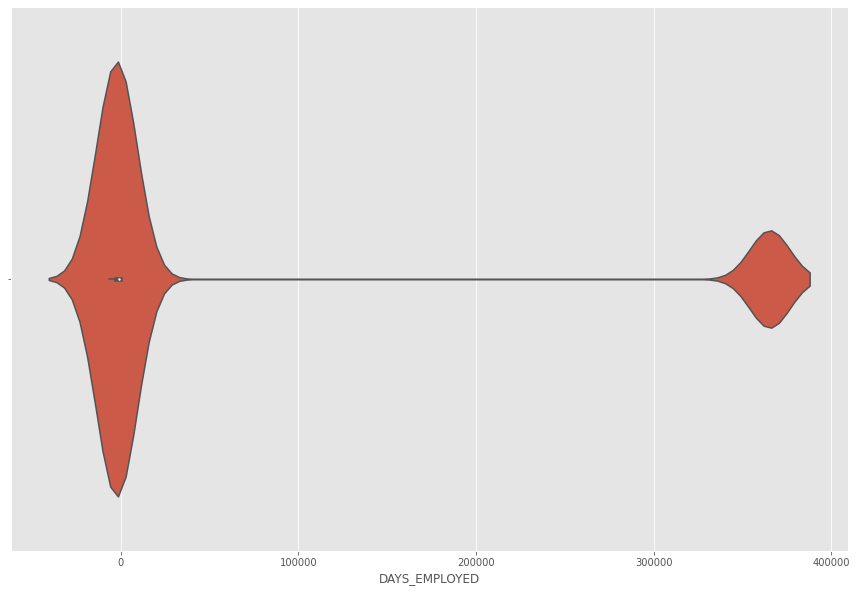

In [ ]:
sns.violinplot(app_train.DAYS_EMPLOYED)

A violin plot of the number of days the borrower has been employed brings up something highly suspicious. The days employed are counted with respect to the current application, so the majority of them are "negative", as is expected. Oddly, there is a giant spike at about 350000 days positive. Since days are counted as days before submition of the application, this makes the positve 350000 spike highly suspect, not to mention it eqauted to  about 800+ years. 

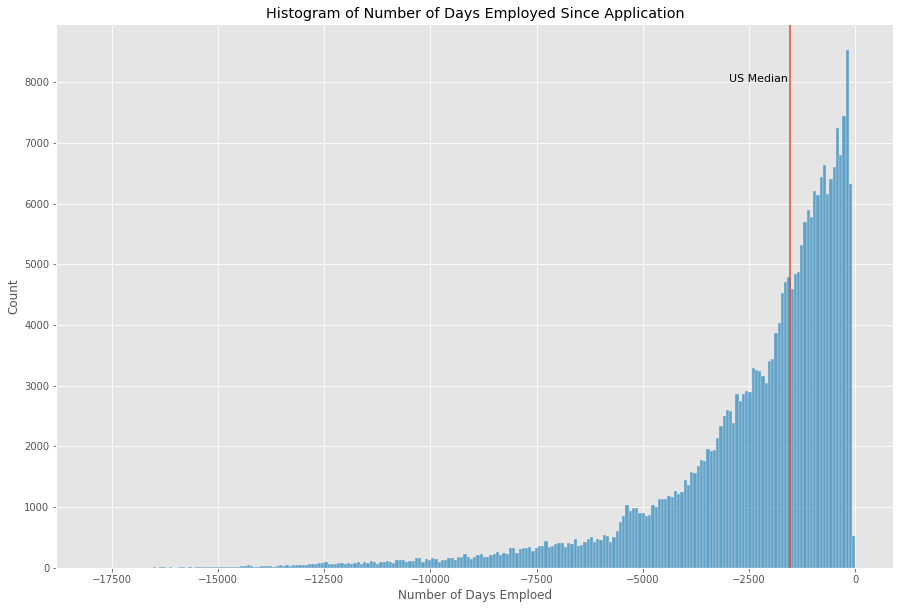

In [ ]:
fig, ax1 = plt.subplots()
sns.histplot(app_train.DAYS_EMPLOYED[app_train.DAYS_EMPLOYED < 10], ax = ax1)
plt.axvline(- 4.2 * 365, 0, 8200)
ax1.set_title("Histogram of Number of Days Employed Since Application")
ax1.set_xlabel("Number of Days Emploed")
ax1.set_ylabel("Count")
ax1.text(- 4.2 * 365 - 1450, 8000, "US Median", fontsize = 11)
plt.show()

Excluding the outliers, the rest of the data exhibits normal behavior and appears to be lognormally distributed. This seems reasonable since according to the Bereau of Labor and Statistics, the median number of years workers tend to stay with the same employer is about 4.2 years in 2020 (assuming this is excluding the rise of unemployment and job losses due to the pandemic). Since Home Credit is primarily based in Asia, I expect the distribution to be similar to the US's but skewed to the lower end, meaning less people being tenured longer with the same employer. Comparing the US median to the dataset shows this to be true. The 4.2 year mark has 56.7% of the applicants being employed less than 4.2 years.

The more interesting question is what is up with the people having a positive employment time, ie the weird ones. 

In [ ]:
len(app_train.DAYS_EMPLOYED[app_train.DAYS_EMPLOYED < - 4.2 * 365]) / len(app_train) * 100

43.30154043269997

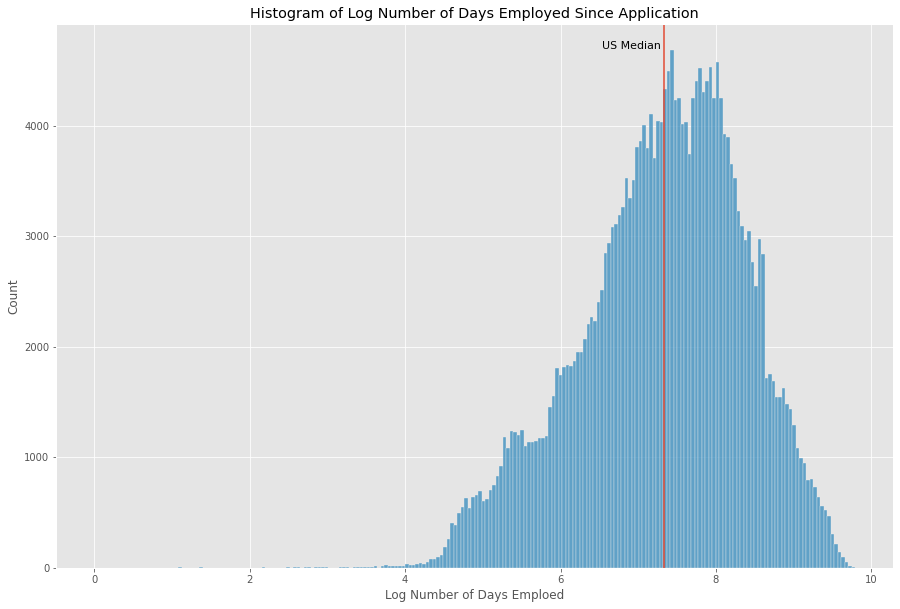

In [ ]:
fig, ax1 = plt.subplots()
sns.histplot(np.log(-1 * app_train.DAYS_EMPLOYED[app_train.DAYS_EMPLOYED < 0]), ax = ax1)
plt.axvline(np.log(4.2 * 365), 0, 8200)
ax1.set_title("Histogram of Log Number of Days Employed Since Application")
ax1.set_xlabel("Log Number of Days Emploed")
ax1.set_ylabel("Count")
ax1.text(np.log(4.2 * 365) - 0.8, 4700, "US Median", fontsize = 11)
plt.show()

#### The Weird Ones

<AxesSubplot:xlabel='DAYS_EMPLOYED', ylabel='Probability'>

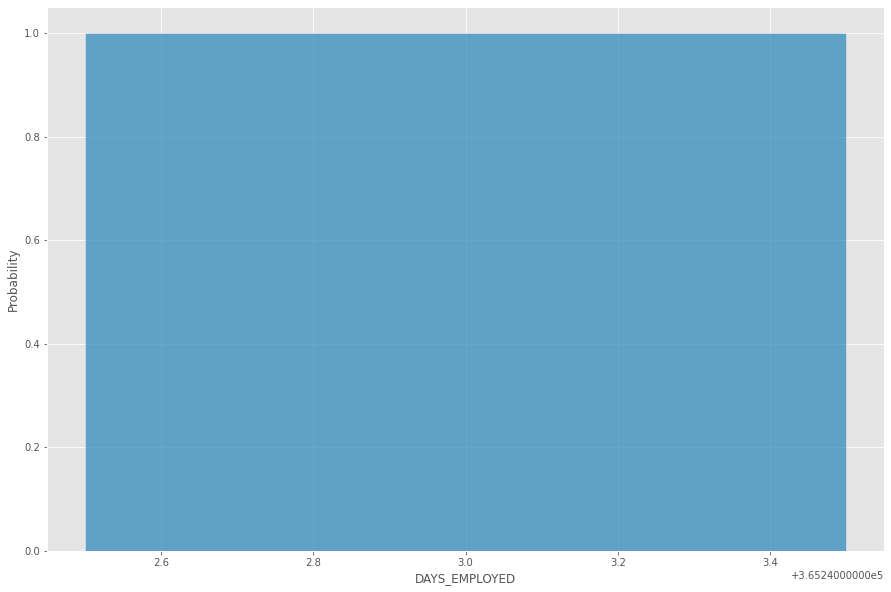

In [ ]:
weird_ones = app_train[app_train.DAYS_EMPLOYED > 0]
sns.histplot(x = weird_ones.DAYS_EMPLOYED, stat = "probability")

The weird ones all have a specific values assigned to them, as if it was done on purpose. They are all concentrated on the value of 365240 days, which translates to 1000 years, which is a long time to be employed(?). Perhaps this is less weird and more compensating for people who are unemployed or something to that extent which was not included in the dataset description instead of leaving the value as missing. 

<AxesSubplot:xlabel='TARGET', ylabel='count'>

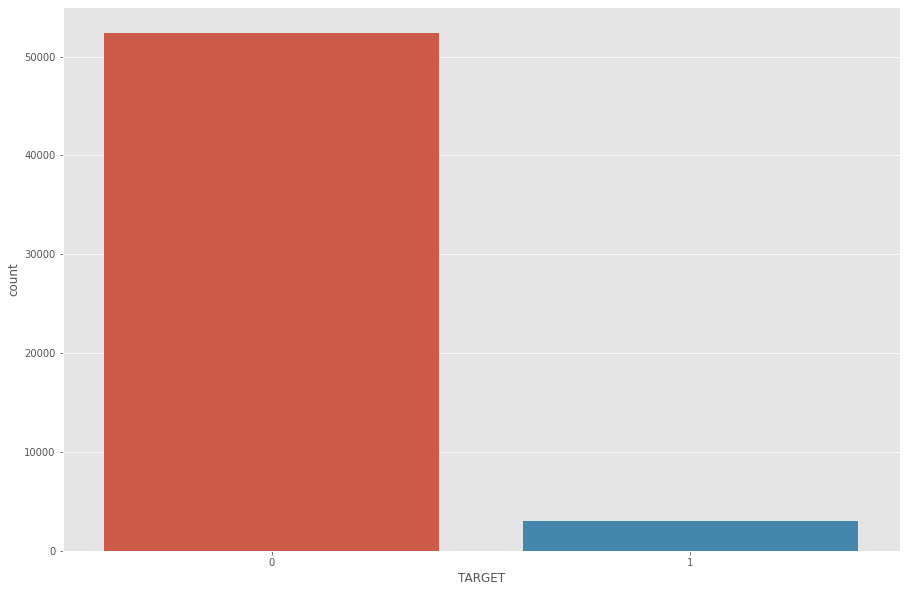

In [ ]:
sns.countplot(x = weird_ones.TARGET)

In [ ]:
df = pd.merge(app_train, weird_ones, on = "SK_ID_CURR", how = "left", indicator = "Weird")
df.Weird = df.Weird == "both"

<AxesSubplot:xlabel='Weird', ylabel='count'>

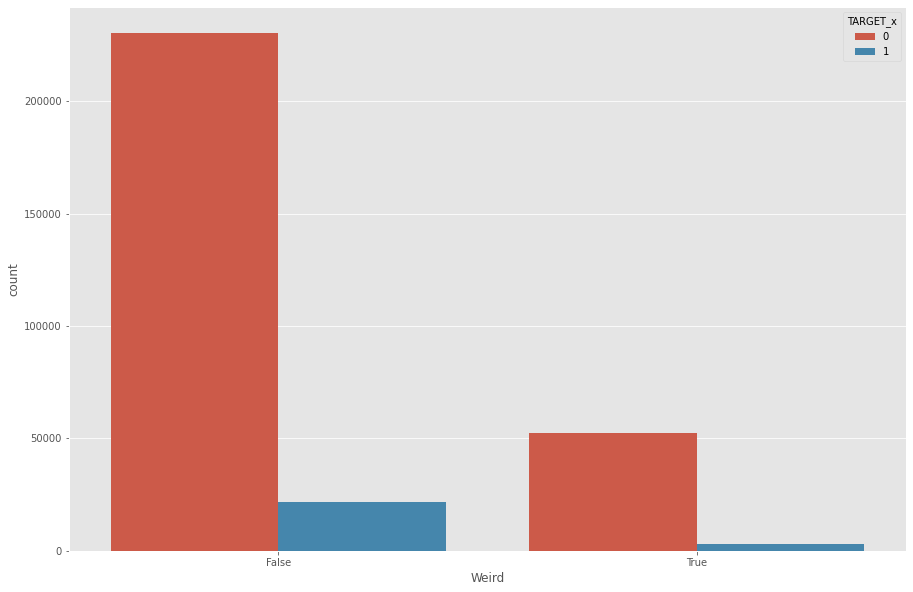

In [ ]:
sns.countplot(x = df.Weird, hue = df.TARGET_x)
# trying to find the percentage of target variable relative to the amount of people in weird group vs non weird

<AxesSubplot:xlabel='Weird', ylabel='percent'>

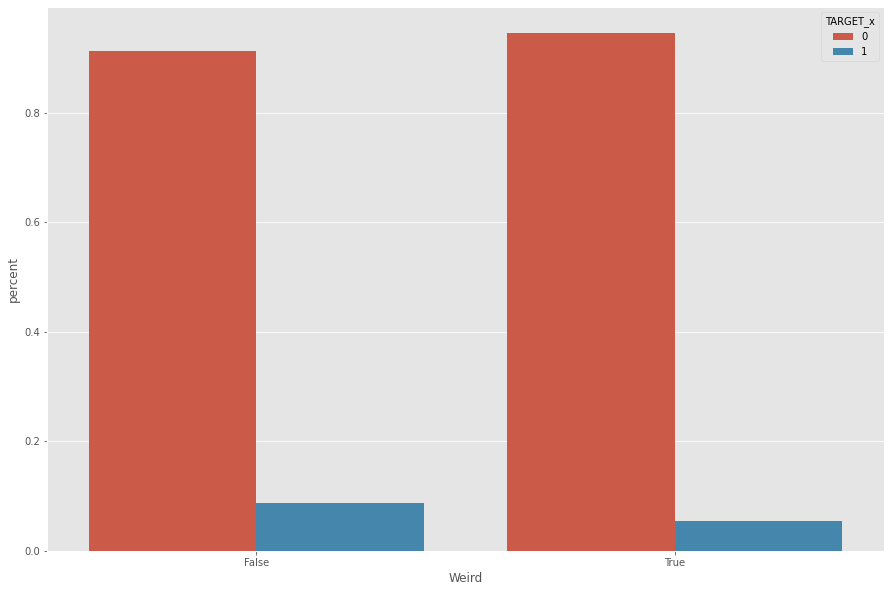

In [ ]:
df1 = df.groupby(["Weird", "TARGET_x"]).TARGET_x.agg(total = "count").reset_index()
df1["percent"] = df1.groupby(by = "Weird").total.apply(lambda x: x / x.sum())
sns.barplot(x = "Weird", y = "percent", data = df1, hue = "TARGET_x")

In [ ]:
contingency_table = pd.crosstab(df.Weird, df.TARGET_x)
contingency_table

TARGET_x,0,1
Weird,,
False,230302,21835
True,52384,2990


In [ ]:
def cramers_v(cross_table):
    chi, p, dofs, exp_cnts = stats.chi2_contingency(cross_table)
    n = cross_table.sum().sum()
    phi = chi / n
    k = cross_table.shape[0]
    r = cross_table.shape[1]
    v = np.sqrt((chi / n) / (min(k-1, r-1)))

    phi_bar = max(0, phi - (k - 1)*(r - 1) / (n - 1))
    k_bar = k - (k-1)**2 / (n-1)
    r_bar = r - (r-1)**2 / (n-1)
    v_corrected = np.sqrt(phi_bar / min(k_bar - 1, r_bar - 1))
    return v, v_corrected, p, chi


def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    mux = np.mean(x)
    muy = np.mean(y)
    sdx = np.std(x, ddof = 1)
    sdy = np.std(y, ddof = 1)
    sd_pooled = np.sqrt( ((nx - 1)*sdx**2 + (ny - 1)*sdy**2) / (nx + ny - 2) )
    return (mux - muy) / sd_pooled

In [ ]:
cram_v, cram_v_corrected, p, chi = cramers_v(contingency_table)
print("The Chi-Squared statistic is %f and \n the corresponding p-value is %f. \n Moreover, the Cramer's V statistic is %f \n and the bias corrected Cramer's V statistic is %f" %(chi, p, cram_v, cram_v_corrected))

The Chi-Squared statistic is 649.888509 and 
 the corresponding p-value is 0.000000. 
 Moreover, the Cramer's V statistic is 0.045972 
 and the bias corrected Cramer's V statistic is 0.045936


<AxesSubplot:xlabel='Weird', ylabel='AMT_INCOME_TOTAL_x'>

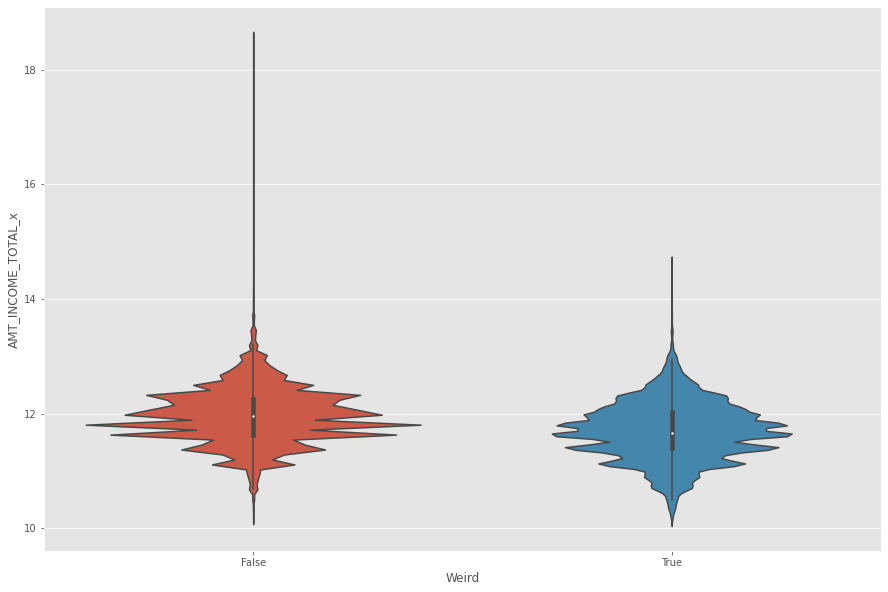

In [ ]:
sns.violinplot(x = df.Weird , y =  np.log(df.AMT_INCOME_TOTAL_x))

In [ ]:
stats.ttest_ind(np.log(df.AMT_INCOME_TOTAL_x[df.Weird == True]), np.log(df.AMT_INCOME_TOTAL_x[df.Weird == False]), equal_var = False)

Ttest_indResult(statistic=-111.80458773557551, pvalue=0.0)

In [ ]:
d = cohens_d(np.log(df.AMT_INCOME_TOTAL_x[df.Weird == True]), np.log(df.AMT_INCOME_TOTAL_x[df.Weird == False]))
np.exp(d)


0.5803273745958207

<AxesSubplot:xlabel='AMT_INCOME_TOTAL_x', ylabel='Density'>

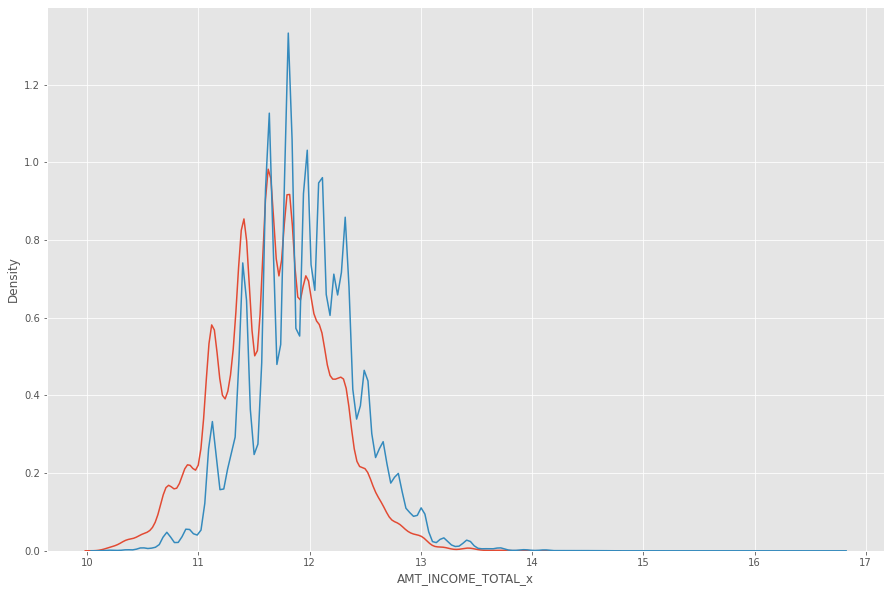

In [ ]:
condition = df.AMT_INCOME_TOTAL_x < 50000000

sns.kdeplot(np.log(df.AMT_INCOME_TOTAL_x[(df.Weird == True) & condition]))
sns.kdeplot(np.log(df.AMT_INCOME_TOTAL_x[(df.Weird == False) & condition]))

In [ ]:
weird_ones.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
8,100011,0,Cash loans,F,N,Y,0,112500.000,1019610.0,33826.5,...,0,0,0,0,0,0,0,0,0,0
11,100015,0,Cash loans,F,N,Y,0,38419.155,148365.0,10678.5,...,0,0,0,0,0,0,0,0,0,0
23,100027,0,Cash loans,F,N,Y,0,83250.000,239850.0,23850.0,...,0,0,0,0,0,0,0,0,0,0
38,100045,0,Cash loans,F,N,Y,0,99000.000,247275.0,17338.5,...,0,0,0,0,0,0,0,0,0,0
43,100050,0,Cash loans,F,N,Y,0,108000.000,746280.0,42970.5,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='CODE_GENDER_x', ylabel='percent'>

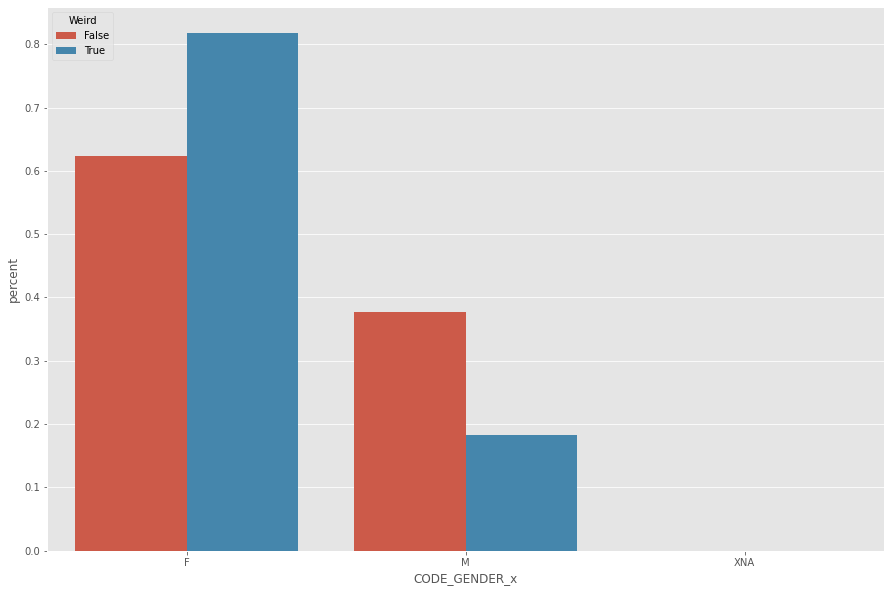

In [ ]:
weird_gender = df.groupby(["Weird", "CODE_GENDER_x"]).CODE_GENDER_x.agg(total = "count").reset_index()
weird_gender["percent"] = weird_gender.groupby("Weird").total.apply(lambda x: x / x.sum())

sns.barplot(data = weird_gender, x = "CODE_GENDER_x", y = "percent", hue = "Weird")

In [ ]:
weird_ones.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
8,100011,0,Cash loans,F,N,Y,0,112500.000,1019610.0,33826.5,...,0,0,0,0,0,0,0,0,0,0
11,100015,0,Cash loans,F,N,Y,0,38419.155,148365.0,10678.5,...,0,0,0,0,0,0,0,0,0,0
23,100027,0,Cash loans,F,N,Y,0,83250.000,239850.0,23850.0,...,0,0,0,0,0,0,0,0,0,0
38,100045,0,Cash loans,F,N,Y,0,99000.000,247275.0,17338.5,...,0,0,0,0,0,0,0,0,0,0
43,100050,0,Cash loans,F,N,Y,0,108000.000,746280.0,42970.5,...,0,0,0,0,0,0,0,0,0,0


<Figure size 864x720 with 0 Axes>

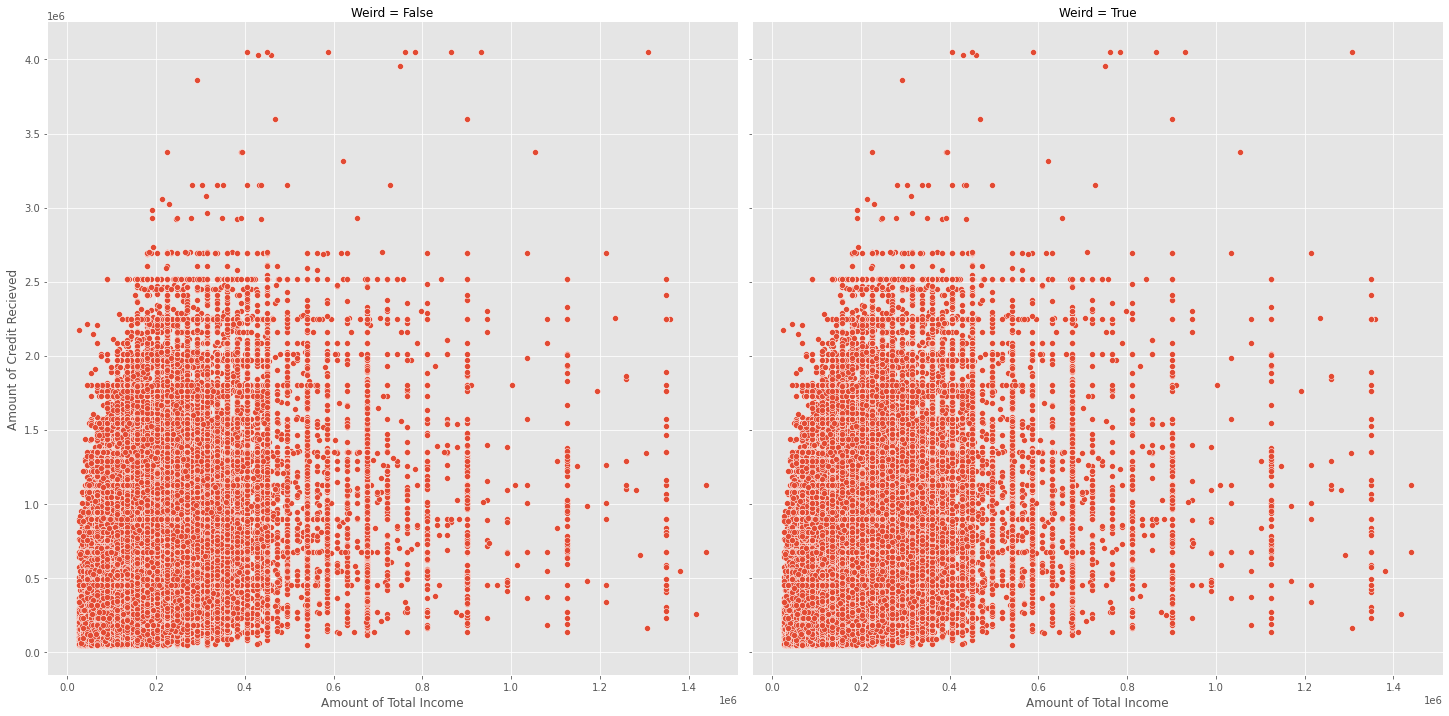

In [ ]:
condition = df.AMT_INCOME_TOTAL_x < 1500000

plt.figure(figsize = (12, 10))
g = sns.FacetGrid(df, col = "Weird", height = 10)
g.map_dataframe(sns.scatterplot, x = df.AMT_INCOME_TOTAL_x[condition], y = df.AMT_CREDIT_x[condition])
g.set_axis_labels("Amount of Total Income", "Amount of Credit Recieved")

<AxesSubplot:xlabel='AMT_INCOME_TOTAL_x', ylabel='AMT_CREDIT_x'>

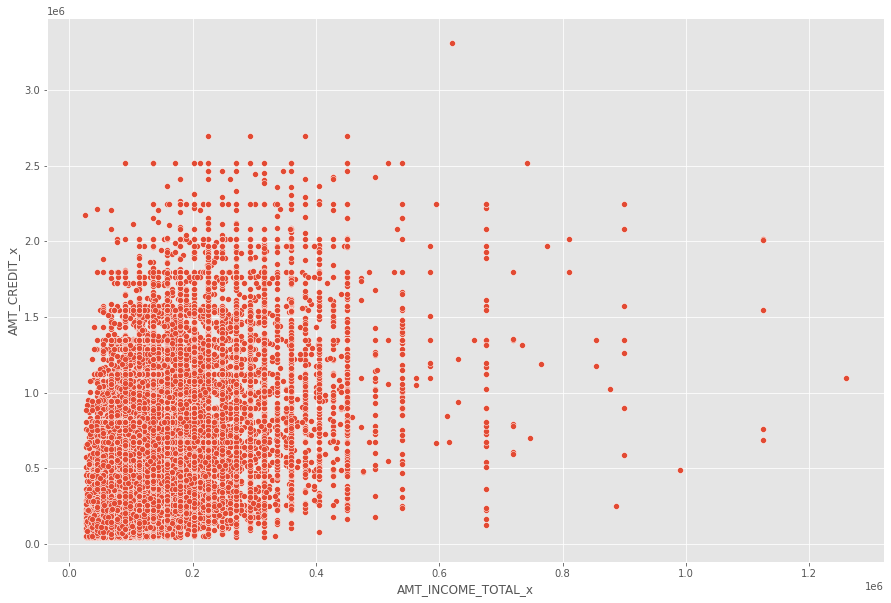

In [ ]:
condition = df.AMT_INCOME_TOTAL_x < 1500000
sns.scatterplot(x = df.AMT_INCOME_TOTAL_x[condition & df.Weird == True], y = df.AMT_CREDIT_x[condition & df.Weird == True])

<AxesSubplot:xlabel='AMT_INCOME_TOTAL_x', ylabel='AMT_CREDIT_x'>

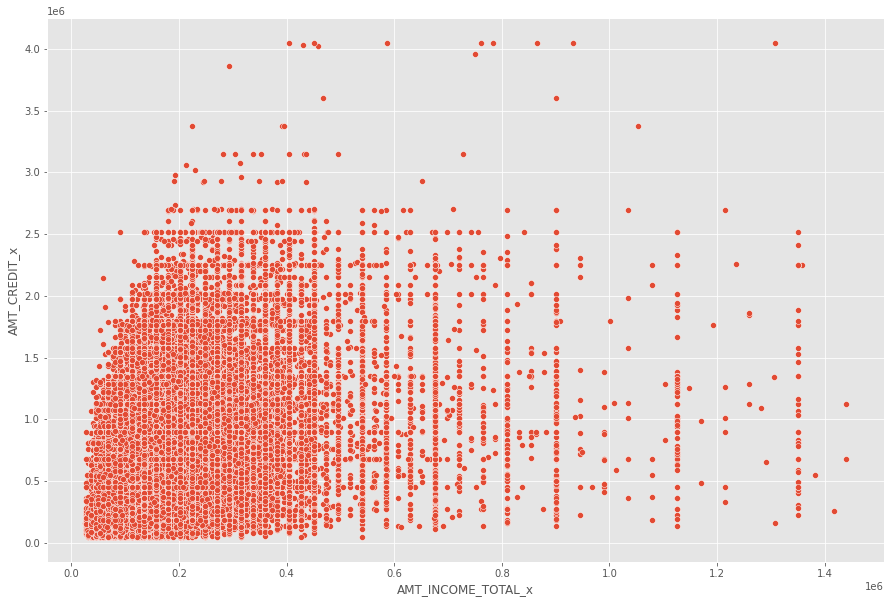

In [ ]:
condition = df.AMT_INCOME_TOTAL_x < 1500000
sns.scatterplot(x = df.AMT_INCOME_TOTAL_x[condition & (df.Weird == False)], y = df.AMT_CREDIT_x[condition & (df.Weird == False)])

<AxesSubplot:xlabel='Weird', ylabel='percent'>

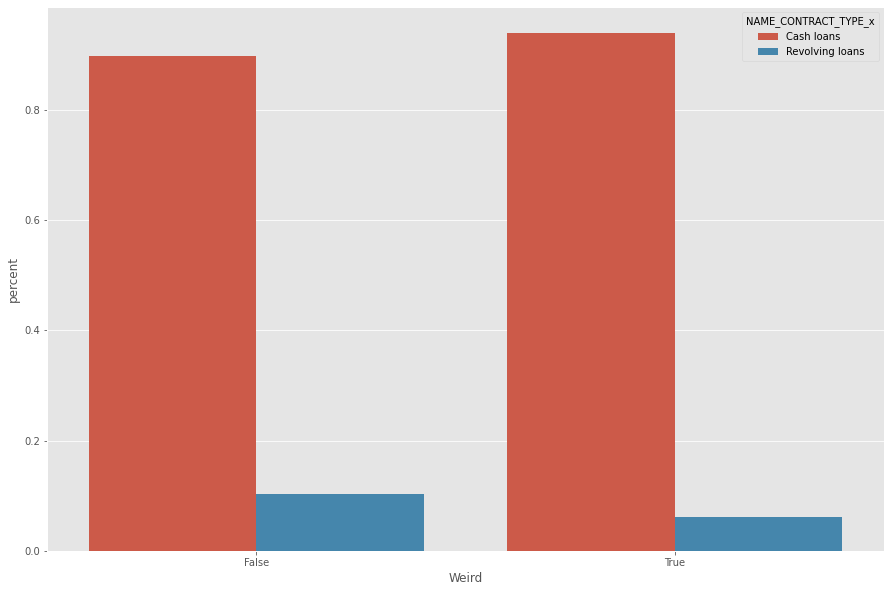

In [ ]:
weird_contracts = df.groupby(["Weird", "NAME_CONTRACT_TYPE_x"]).NAME_CONTRACT_TYPE_x.agg(total = "count").reset_index()
weird_contracts['percent'] = weird_contracts.groupby(["Weird"]).total.apply(lambda x: x / x.sum())
sns.barplot(data = weird_contracts, x = "Weird", y = "percent" ,hue = "NAME_CONTRACT_TYPE_x")

In [ ]:
weird_ones.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
8,100011,0,Cash loans,F,N,Y,0,112500.000,1019610.0,33826.5,...,0,0,0,0,0,0,0,0,0,0
11,100015,0,Cash loans,F,N,Y,0,38419.155,148365.0,10678.5,...,0,0,0,0,0,0,0,0,0,0
23,100027,0,Cash loans,F,N,Y,0,83250.000,239850.0,23850.0,...,0,0,0,0,0,0,0,0,0,0
38,100045,0,Cash loans,F,N,Y,0,99000.000,247275.0,17338.5,...,0,0,0,0,0,0,0,0,0,0
43,100050,0,Cash loans,F,N,Y,0,108000.000,746280.0,42970.5,...,0,0,0,0,0,0,0,0,0,0


Text(0.5, 1.0, 'Marital Status Distribution of People in the Weird Category')

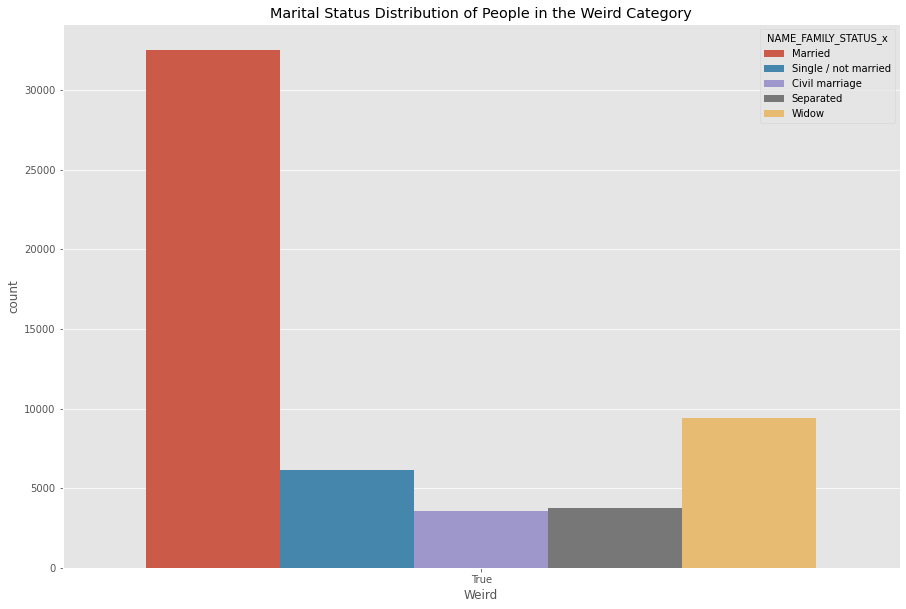

In [ ]:
condition = df.Weird == True
sns.countplot(x = df.Weird[condition], hue = df.NAME_FAMILY_STATUS_x[condition])
plt.title("Marital Status Distribution of People in the Weird Category")

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


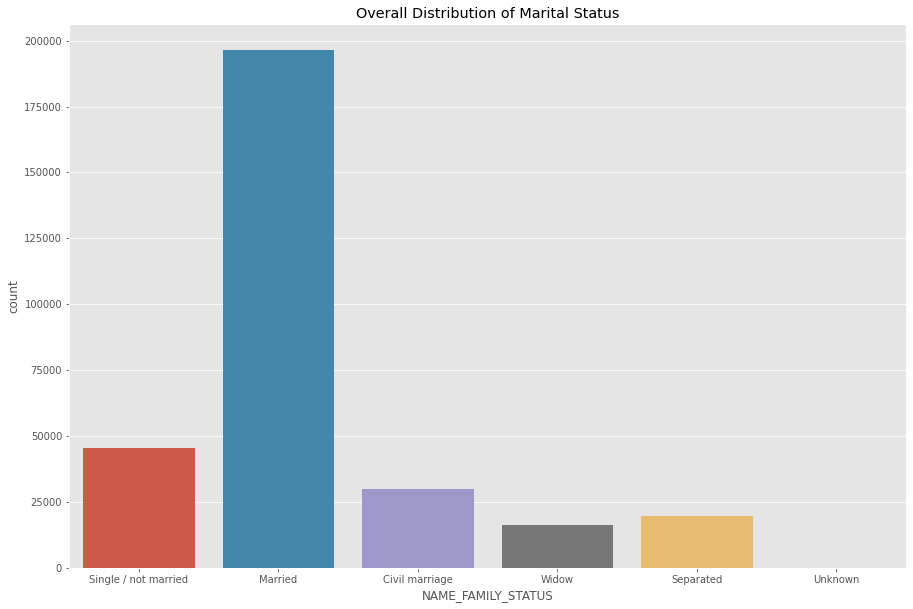

In [ ]:
sns.countplot(app_train.NAME_FAMILY_STATUS)
plt.title("Overall Distribution of Marital Status")
plt.show()

<AxesSubplot:xlabel='NAME_FAMILY_STATUS_x', ylabel='percent'>

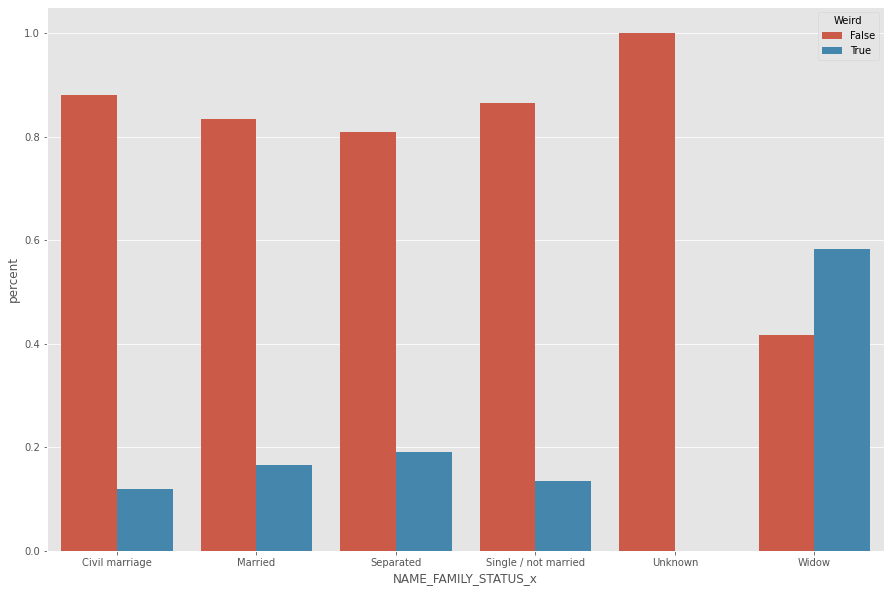

In [ ]:
weird_married = df.groupby(["NAME_FAMILY_STATUS_x", "Weird"]).NAME_FAMILY_STATUS_x.agg(total = "count").reset_index()
weird_married["percent"] = weird_married.groupby("NAME_FAMILY_STATUS_x").total.apply(lambda x: x/x.sum())
weird_married

sns.barplot(data = weird_married, x = "NAME_FAMILY_STATUS_x", y = "percent", hue = "Weird")

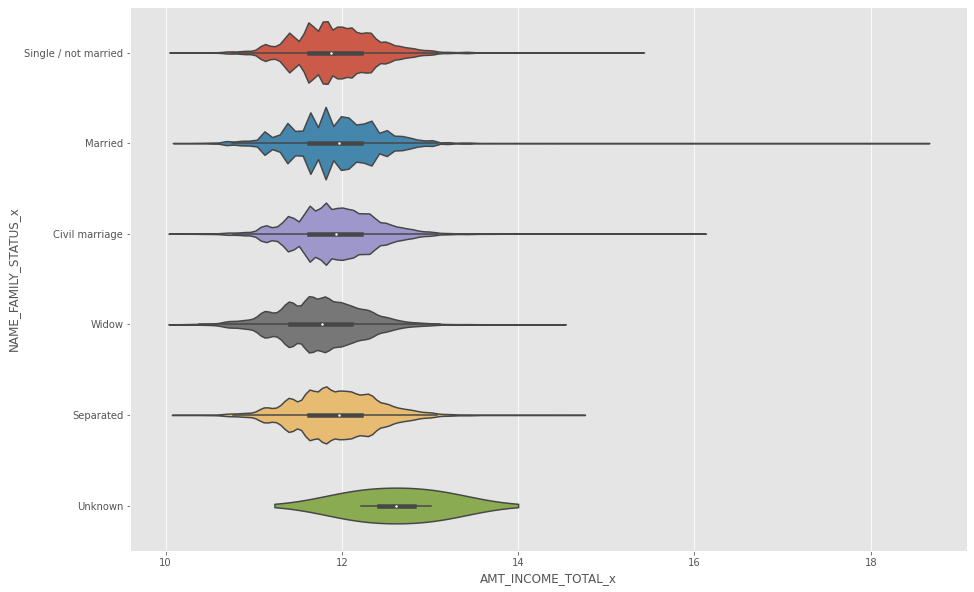

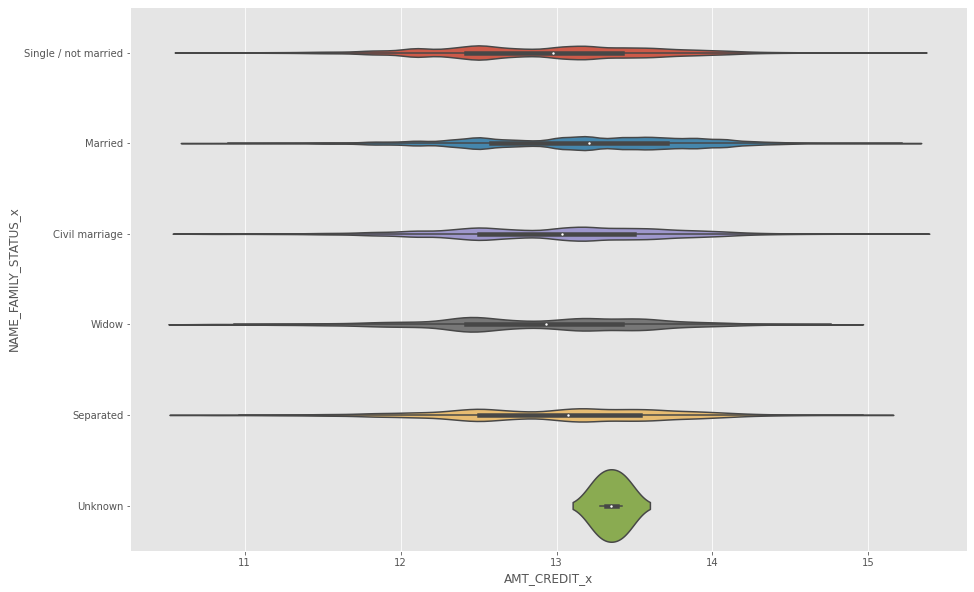

In [ ]:
sns.violinplot(x = np.log(df.AMT_INCOME_TOTAL_x), y = df.NAME_FAMILY_STATUS_x)
plt.show()
sns.violinplot(x = np.log(df.AMT_CREDIT_x), y = df.NAME_FAMILY_STATUS_x)
plt.show()

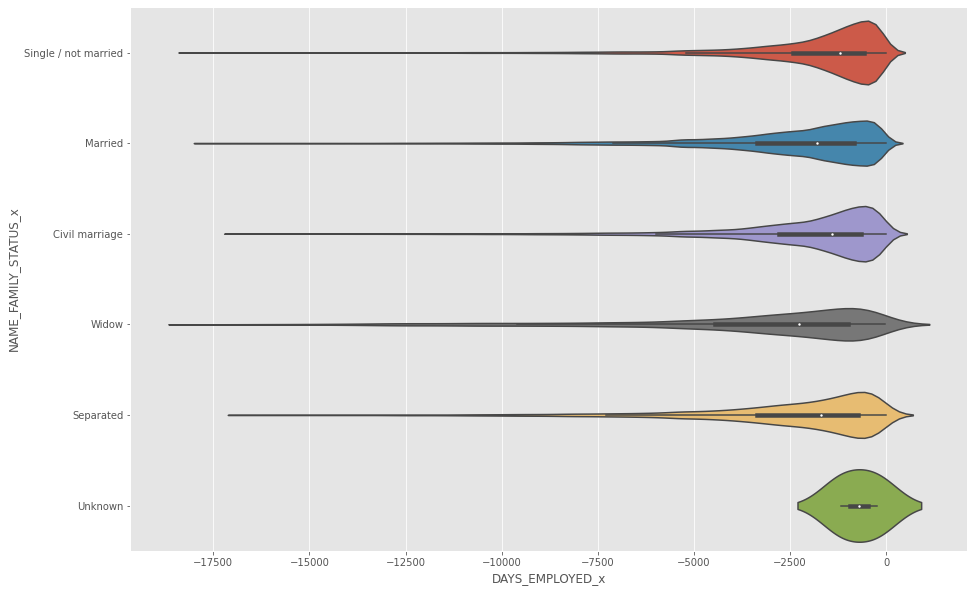

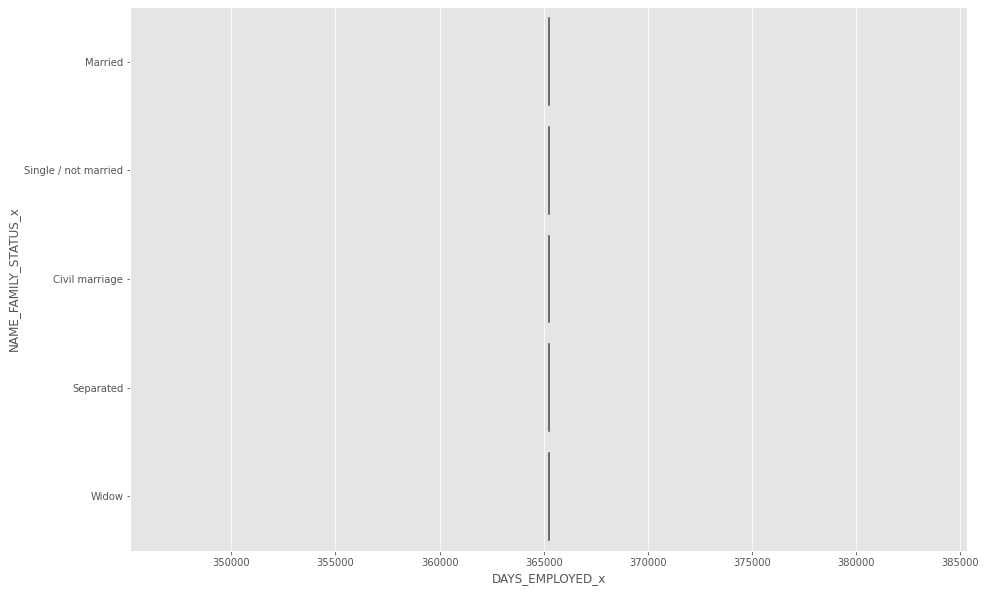

In [ ]:
condition = df.DAYS_EMPLOYED_x < 0
sns.violinplot(y = df.NAME_FAMILY_STATUS_x[condition], x = df.DAYS_EMPLOYED_x[condition])
plt.show()

condition = df.DAYS_EMPLOYED_x > 0
sns.violinplot(y = df.NAME_FAMILY_STATUS_x[condition], x = df.DAYS_EMPLOYED_x[condition])
plt.show()

   Weird    NAME_INCOME_TYPE_x   total   Percent
0  False           Businessman      10  0.000040
1  False  Commercial associate   71617  0.284040
2  False       Maternity leave       5  0.000020
3  False             Pensioner      10  0.000040
4  False         State servant   21703  0.086076
5  False               Student      18  0.000071
6  False               Working  158774  0.629713
7   True             Pensioner   55352  0.999603
8   True            Unemployed      22  0.000397


<AxesSubplot:xlabel='NAME_INCOME_TYPE_x', ylabel='Percent'>

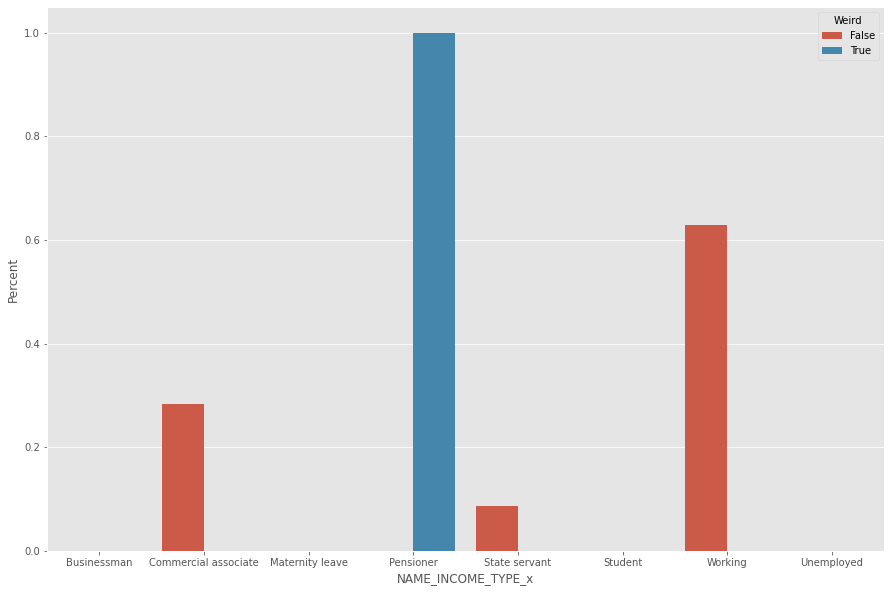

In [ ]:
income_type = df.groupby(["Weird", "NAME_INCOME_TYPE_x"]).NAME_INCOME_TYPE_x.agg(total = "count").reset_index()
income_type["Percent"] = income_type.groupby("Weird").total.apply(lambda x: x/x.sum())
print(income_type)

sns.barplot(x = income_type.NAME_INCOME_TYPE_x, y = income_type.Percent, hue = income_type.Weird)

<AxesSubplot:xlabel='DAYS_EMPLOYED', ylabel='NAME_INCOME_TYPE'>

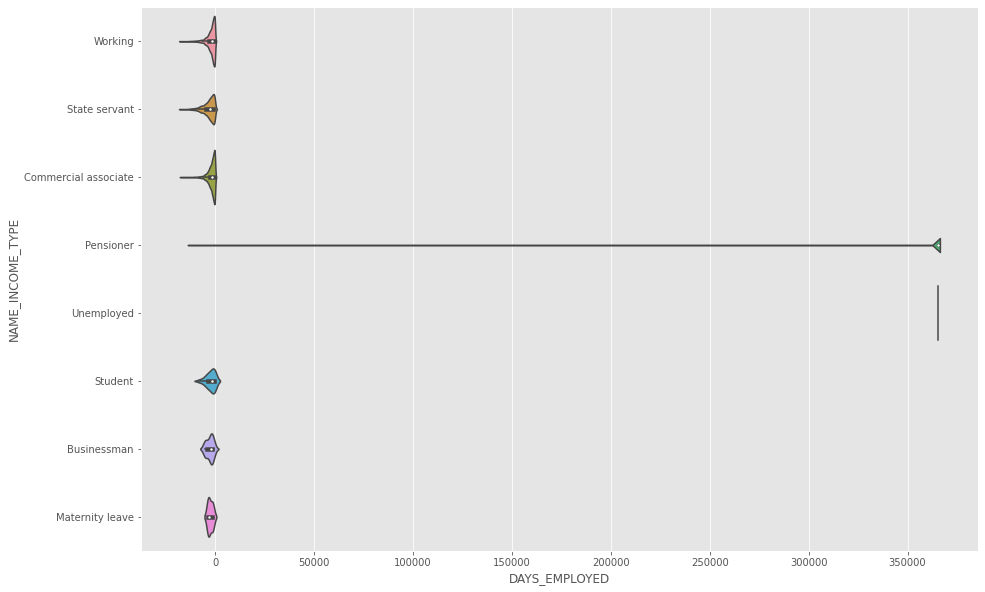

In [ ]:
sns.violinplot(x = app_train.DAYS_EMPLOYED, y = app_train.NAME_INCOME_TYPE)

<AxesSubplot:xlabel='NAME_INCOME_TYPE_x', ylabel='count'>

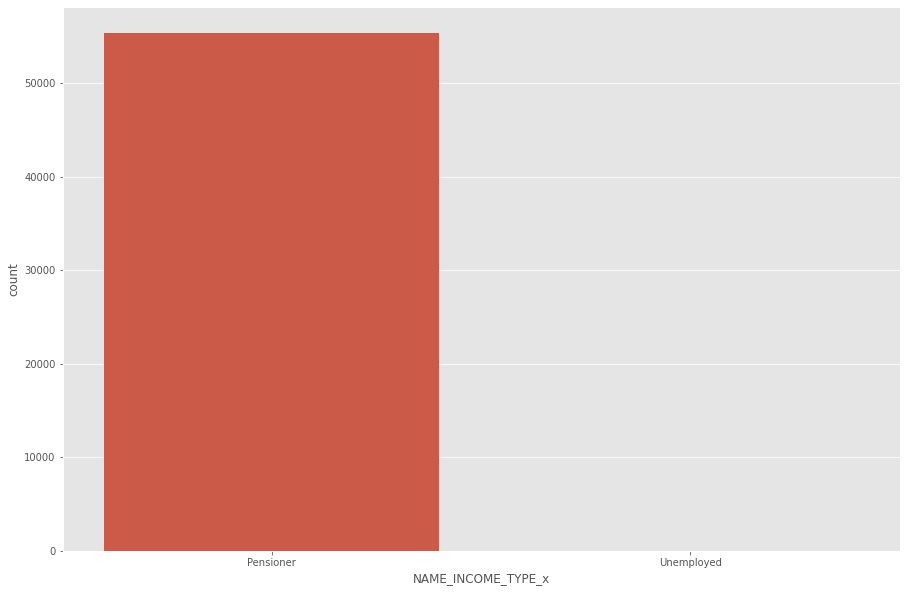

In [ ]:
condition = df.Weird == True
sns.countplot(x = df.NAME_INCOME_TYPE_x[condition])

<AxesSubplot:xlabel='DAYS_EMPLOYED', ylabel='Count'>

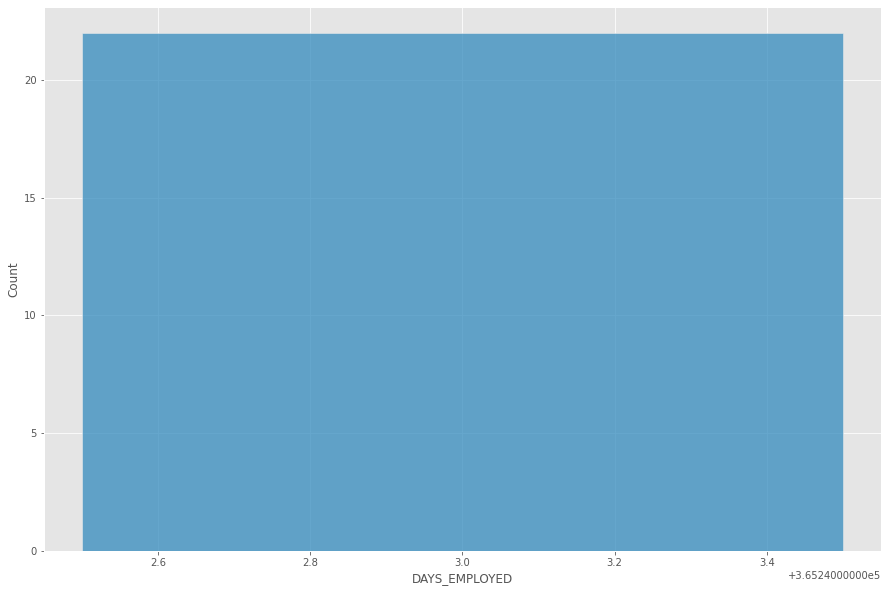

In [ ]:
condition = app_train.NAME_INCOME_TYPE == "Unemployed"
sns.histplot(x = app_train[condition].DAYS_EMPLOYED)

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
Working                 0.516320
Commercial associate    0.232892
Pensioner               0.180033
State servant           0.070576
Unemployed              0.000072
Student                 0.000059
Businessman             0.000033
Maternity leave         0.000016
Name: NAME_INCOME_TYPE, dtype: float64


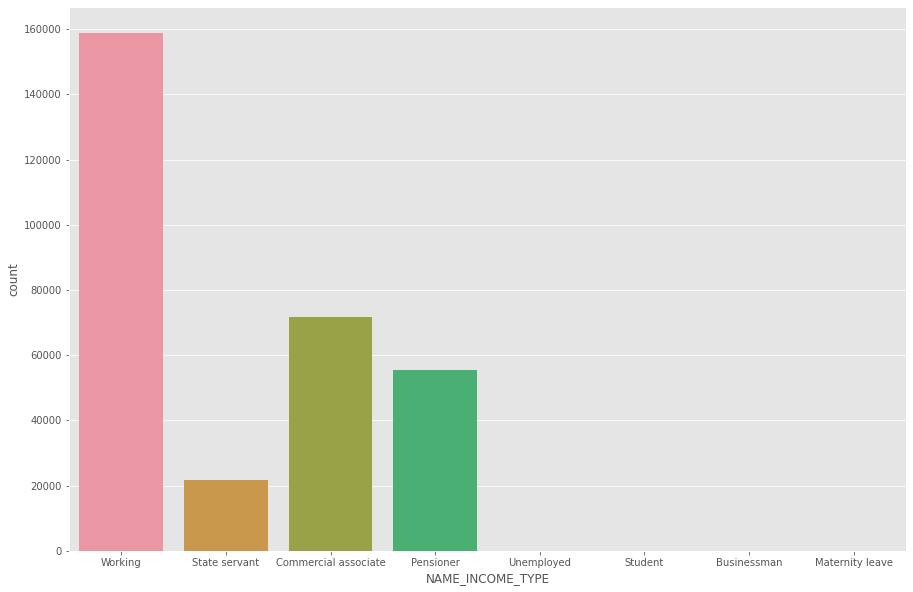

In [ ]:
sns.countplot(app_train.NAME_INCOME_TYPE)
print(app_train.NAME_INCOME_TYPE.value_counts() / len(app_train))

In [ ]:
len(weird_ones) / len(app_train)

0.18007160719453938

#### Weird Ones Summary
_Note: The days of employment variable is meant to track how long each borrower has been employed in their current occupation and is measured as the number of days prior to the application date, thus a majority of the values are 0 or a negative number. The borrowers denoted as weird have a positive value of number of days employed prior to the application, which does not make sense._

My findings of the subset of people having an odd range of employment, dubbed the weird ones, includes:
- a disproportionate amount of people in the subset are women
- they typically earn less than people who are not in the "Weird" category
- Most of the people are married, but that stems from the fact that the majority of borrowers in the dataset are married.
    - interestingly, a majority of the widows from the entire dataset tend to fall in the weird category.
    
- **Solution:** After some further exploration, the most likely answer as to why they have an odd amount of number of days employed is found under the variable describing their type of income. The vast majority of borrowers (> 99%) in the weird category are pensioners, meaning they are retired, which also goes on to explain why a relatively large proportion of them are widowers. It also makes sense since they are not currently employed and thus have to input some value. Now to solve this problem for model building.

In [ ]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='DAYS_ID_PUBLISH', ylabel='Density'>

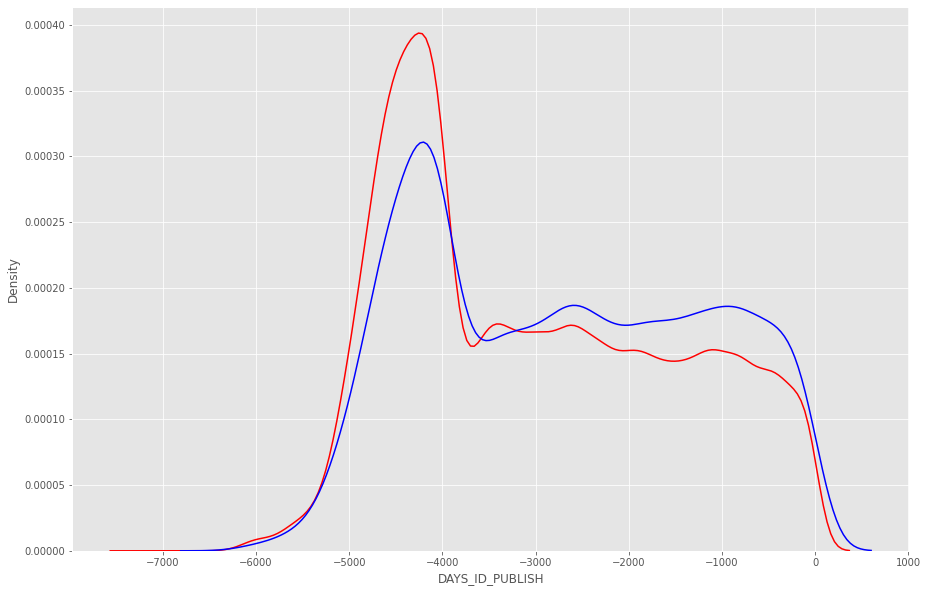

In [ ]:
sns.kdeplot(x = app_train.DAYS_ID_PUBLISH[app_train.TARGET == 0], color = "red")
sns.kdeplot(x = app_train.DAYS_ID_PUBLISH[app_train.TARGET == 1], color = "blue")


<AxesSubplot:xlabel='DAYS_REGISTRATION', ylabel='Density'>

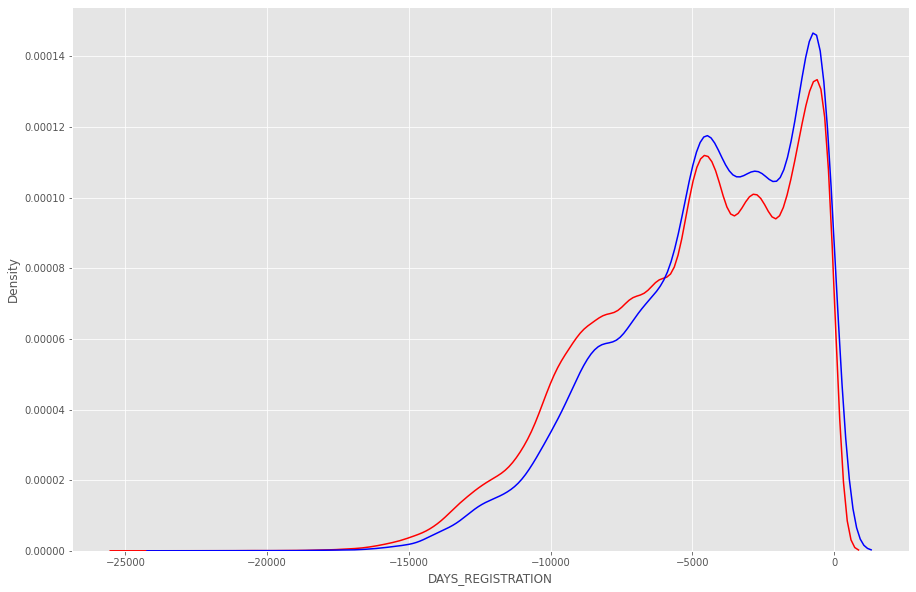

In [ ]:
sns.kdeplot(x = app_train.DAYS_REGISTRATION[app_train.TARGET == 0], color = "red")
sns.kdeplot(x = app_train.DAYS_REGISTRATION[app_train.TARGET == 1], color = "blue")

<AxesSubplot:xlabel='DAYS_BIRTH', ylabel='Density'>

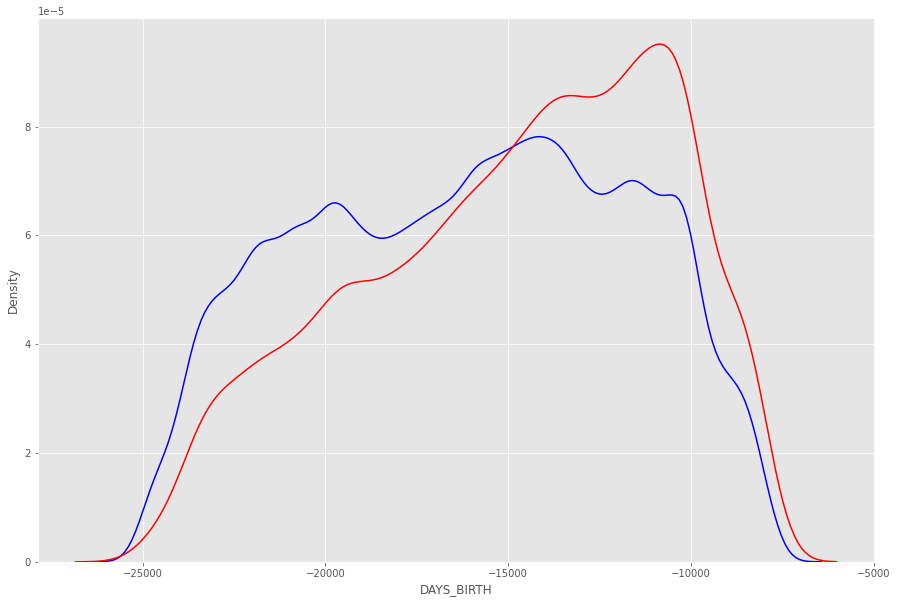

In [ ]:
sns.kdeplot(x = app_train.DAYS_BIRTH[app_train.TARGET == 0], color = "blue")
sns.kdeplot(x = app_train.DAYS_BIRTH[app_train.TARGET == 1], color = "red")

<AxesSubplot:xlabel='AMT_CREDIT', ylabel='TARGET'>

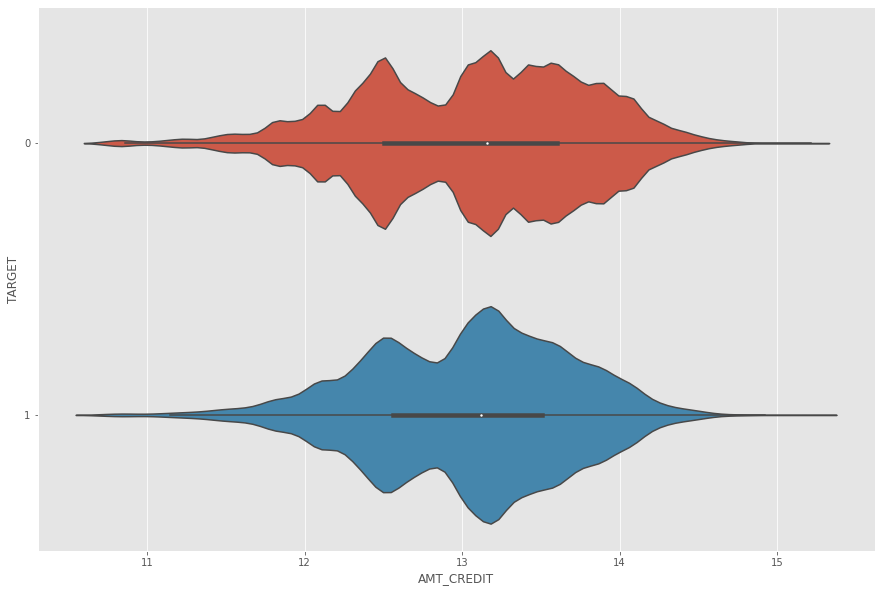

In [ ]:
sns.violinplot(x =  np.log(app_train.AMT_CREDIT), y = app_train.TARGET)

In [ ]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0


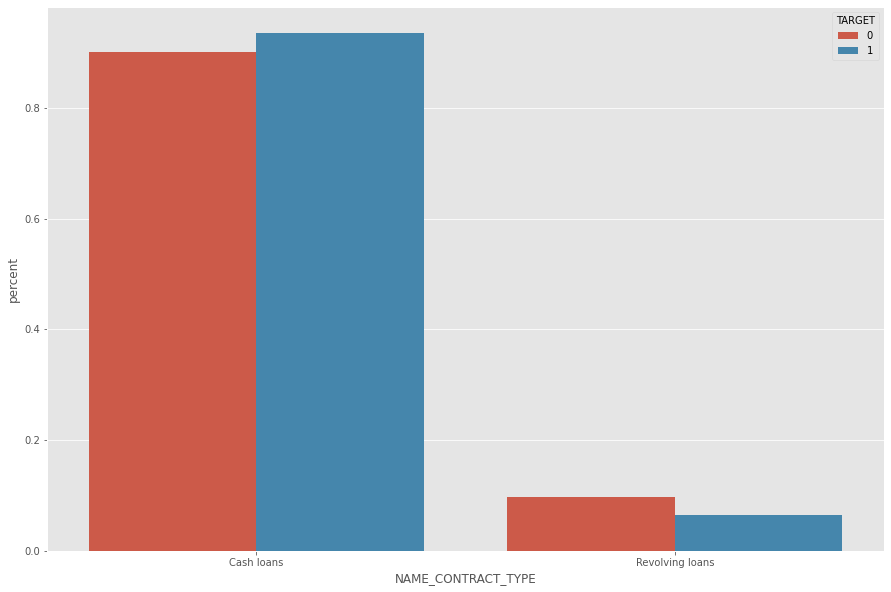

(293.15054219964554,
 1.0235150721172847e-65,
 1,
 array([[255770.65910488,  26915.34089512],
        [ 22461.34089512,   2363.65910488]]))

In [ ]:
contract_type = app_train.groupby(["NAME_CONTRACT_TYPE", "TARGET"]).NAME_CONTRACT_TYPE.agg(total = "count").reset_index()
contract_type["percent"] = contract_type.groupby("TARGET").total.apply(lambda x: x/x.sum())

sns.barplot(x = contract_type.NAME_CONTRACT_TYPE, y =contract_type.percent, hue = contract_type.TARGET)
plt.show()

contract_cont = pd.crosstab(app_train.TARGET, app_train.NAME_CONTRACT_TYPE)
stats.chi2_contingency(contract_cont)

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='NAME_CONTRACT_TYPE', ylabel='AMT_INCOME_TOTAL'>

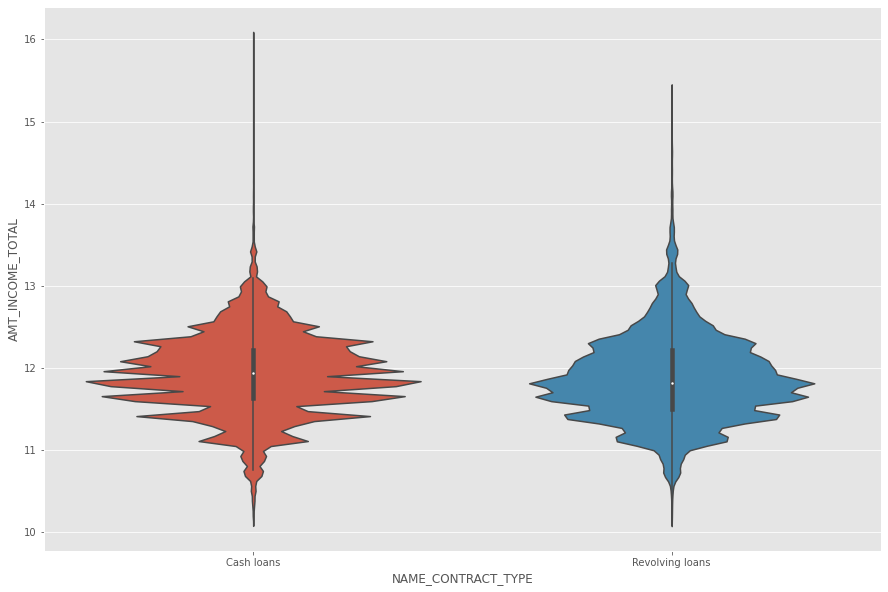

In [ ]:
condition = app_train.AMT_INCOME_TOTAL < 10000000
sns.violinplot(app_train.NAME_CONTRACT_TYPE[condition], np.log(app_train.AMT_INCOME_TOTAL[condition]))

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='NAME_CONTRACT_TYPE', ylabel='AMT_CREDIT'>

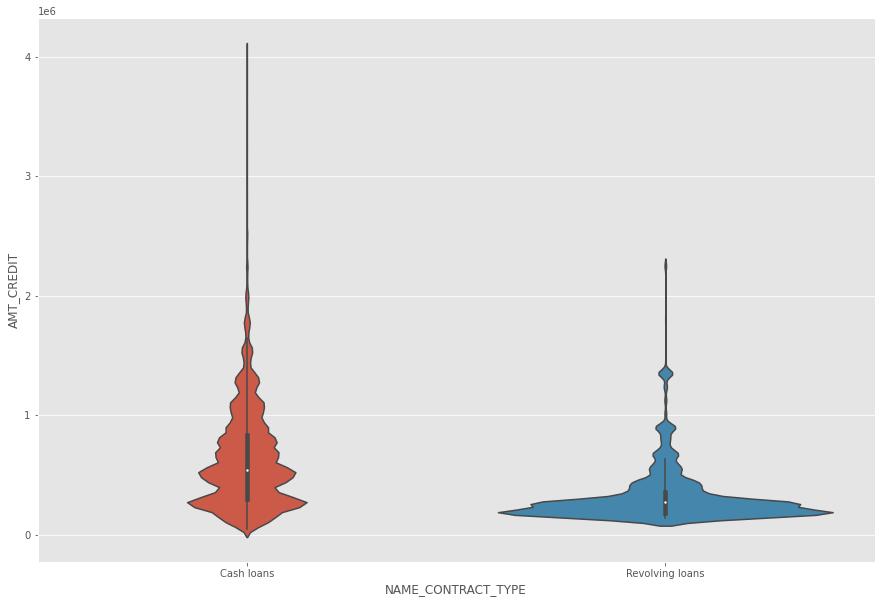

In [ ]:
sns.violinplot(app_train.NAME_CONTRACT_TYPE, (app_train.AMT_CREDIT))

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='NAME_CONTRACT_TYPE', ylabel='AMT_GOODS_PRICE'>

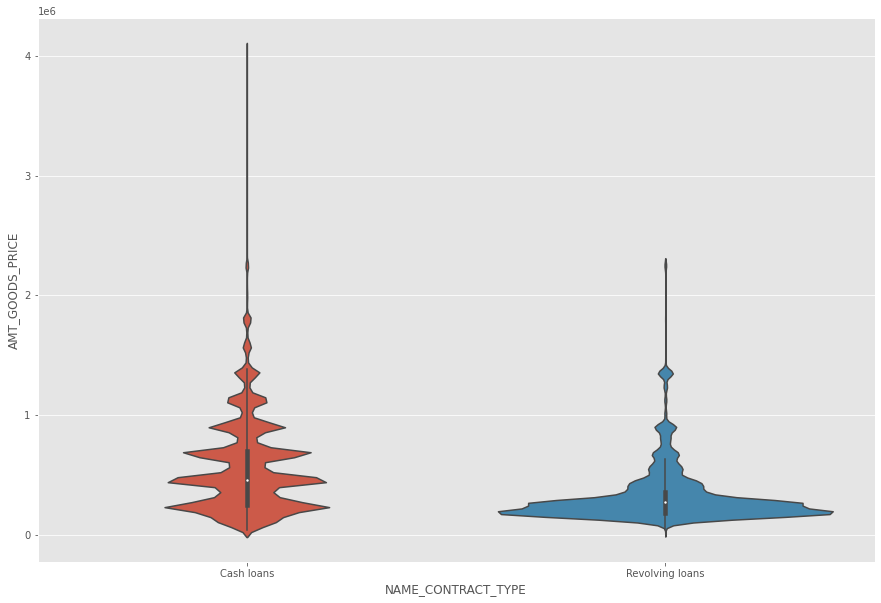

In [ ]:
sns.violinplot(app_train.NAME_CONTRACT_TYPE, (app_train.AMT_GOODS_PRICE))

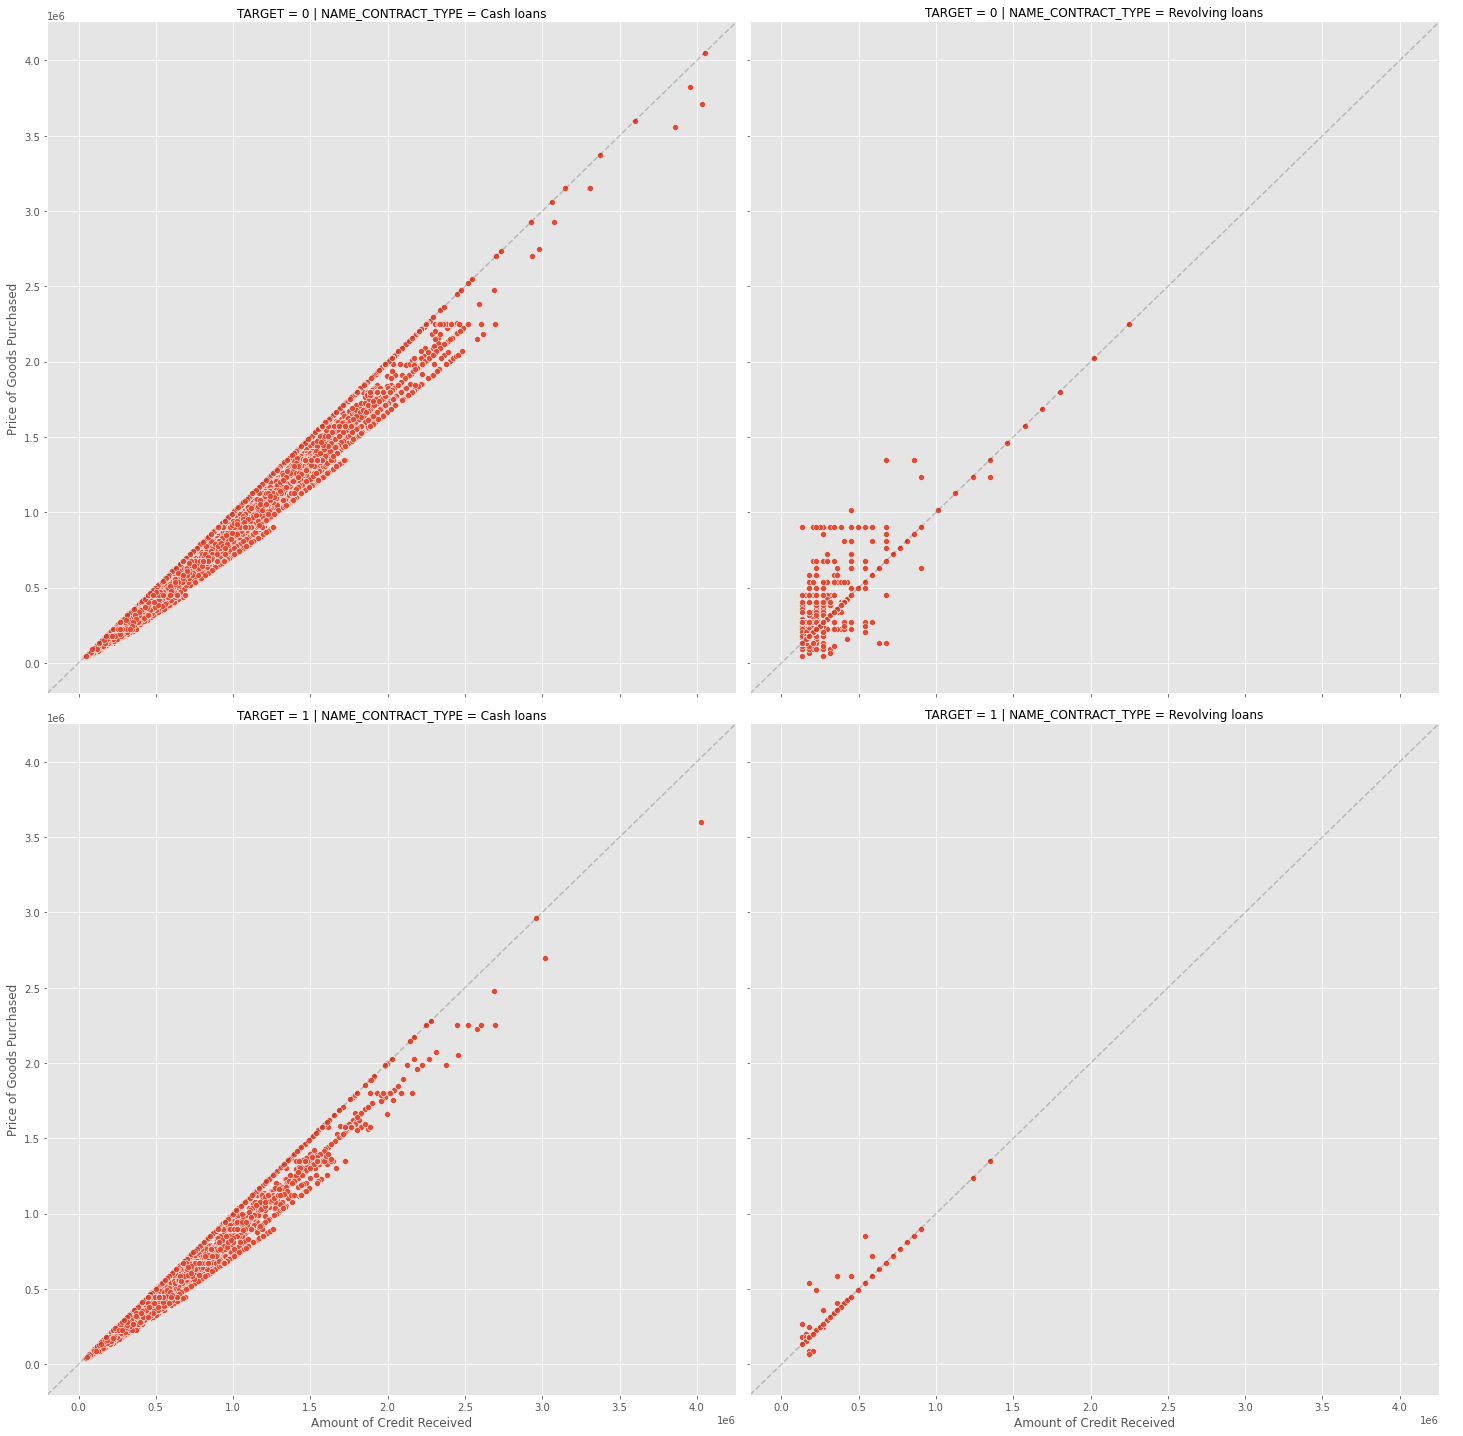

In [ ]:
g = sns.FacetGrid(app_train, col = "NAME_CONTRACT_TYPE", height = 10, row = "TARGET")
g.map_dataframe(sns.scatterplot, y = "AMT_GOODS_PRICE", x = "AMT_CREDIT")
g.set_ylabels("Price of Goods Purchased")
g.set_xlabels("Amount of Credit Received")
g.add_legend()
for ax in g.axes.flat:
    ax.axline((0, 0), slope = 1, ls = "--", alpha = 0.2, color = "black")

In [ ]:
print("There are %d people buying goods worth more than the cash loans they were approved for" %len(app_train[(app_train.NAME_CONTRACT_TYPE == "Cash loans") & (app_train.AMT_CREDIT < app_train.AMT_GOODS_PRICE)]))
print("There are %d people buying goods worth more than the revolving loans they were approved for" %len(app_train[(app_train.NAME_CONTRACT_TYPE == "Revolving loans") & (app_train.AMT_CREDIT < app_train.AMT_GOODS_PRICE)]))

There are 0 people buying goods worth more than the cash loans they were approved for
There are 260 people buying goods worth more than the revolving loans they were approved for


### Education

<AxesSubplot:xlabel='NAME_EDUCATION_TYPE', ylabel='Percent'>

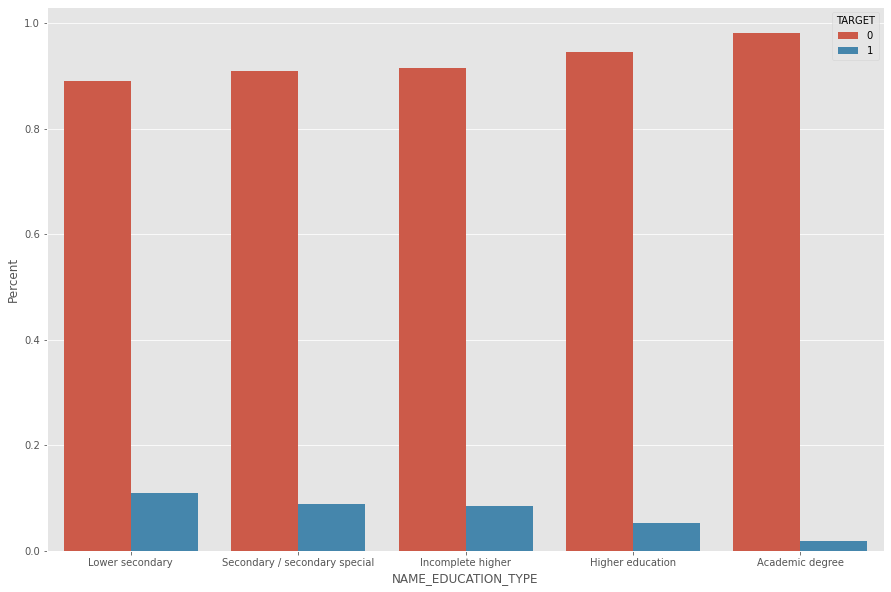

In [ ]:
order = ["Lower secondary", "Secondary / secondary special", "Incomplete higher", "Higher education", "Academic degree"]
education_type = app_train.groupby(["NAME_EDUCATION_TYPE", "TARGET"]).NAME_EDUCATION_TYPE.agg(total = "count").reset_index()
education_type['Percent'] = education_type.groupby("NAME_EDUCATION_TYPE").total.apply(lambda x: x / x.sum())

sns.barplot(x = education_type.NAME_EDUCATION_TYPE, y = education_type.Percent, hue = education_type.TARGET, order = order)

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='NAME_EDUCATION_TYPE', ylabel='count'>

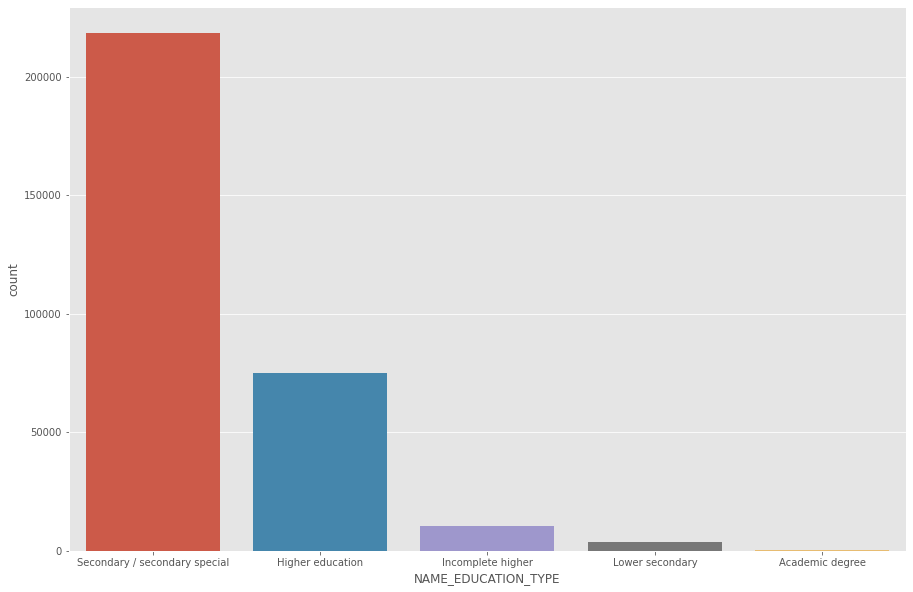

In [ ]:
sns.countplot(app_train.NAME_EDUCATION_TYPE)

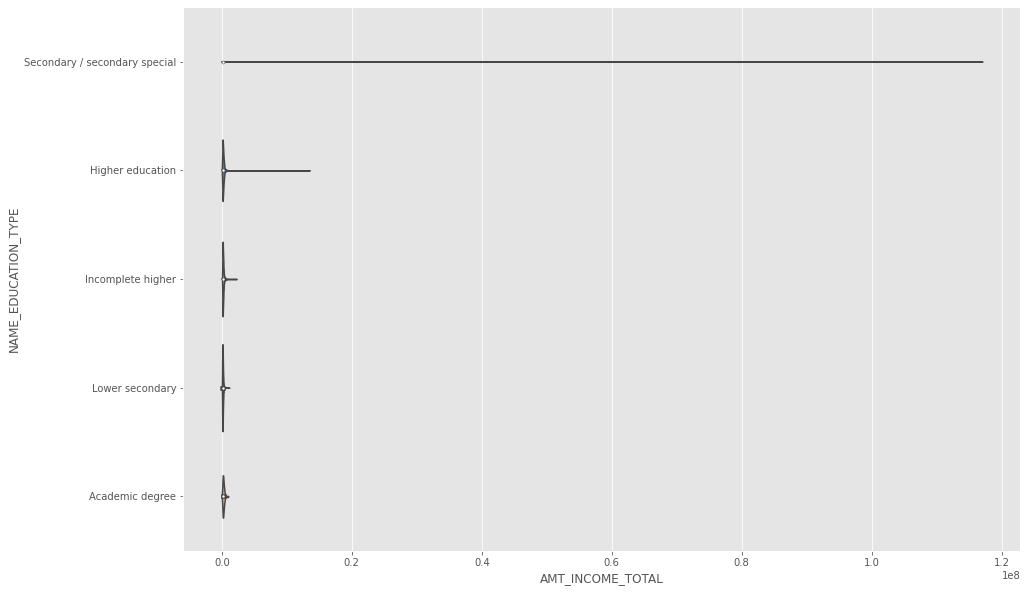

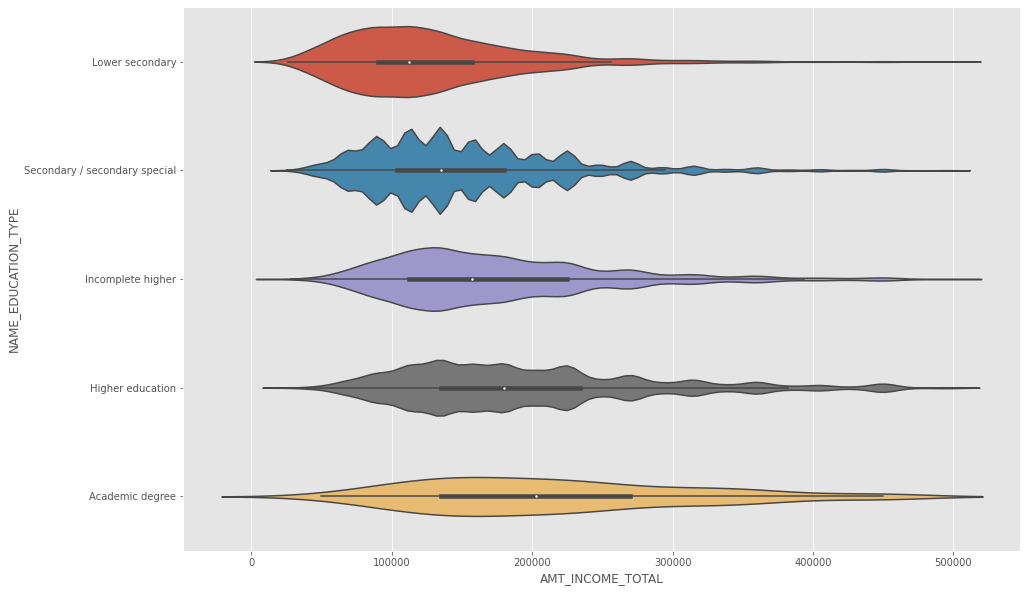

In [ ]:
order = ["Lower secondary", "Secondary / secondary special", "Incomplete higher", "Higher education", "Academic degree"]
condition = app_train.AMT_INCOME_TOTAL < 500000

sns.violinplot(y = app_train.NAME_EDUCATION_TYPE, x = (app_train.AMT_INCOME_TOTAL))
plt.show()
sns.violinplot(y = app_train.NAME_EDUCATION_TYPE[condition], x = (app_train.AMT_INCOME_TOTAL[condition]), order = order)
plt.show()

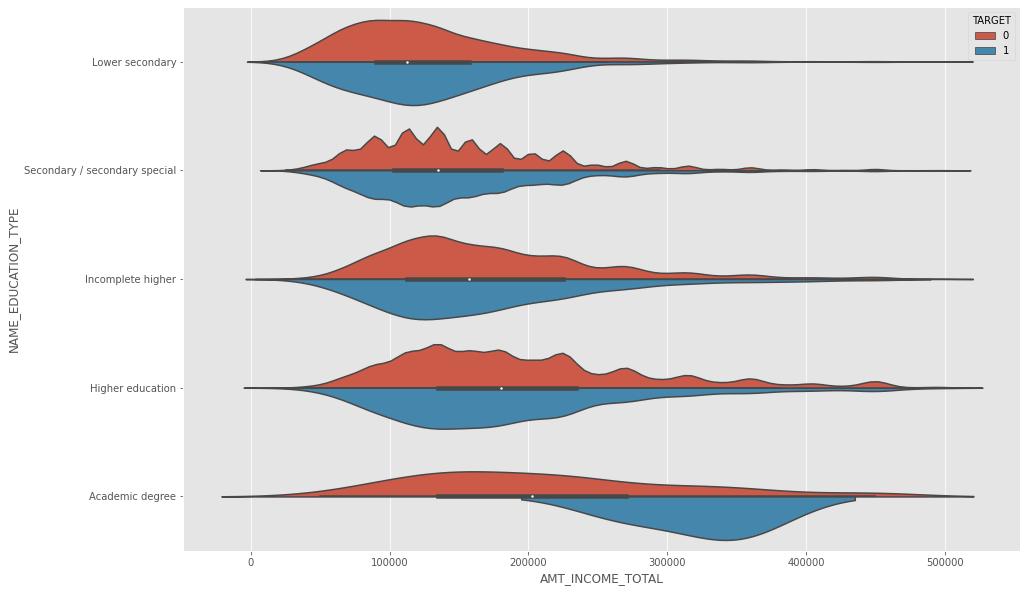

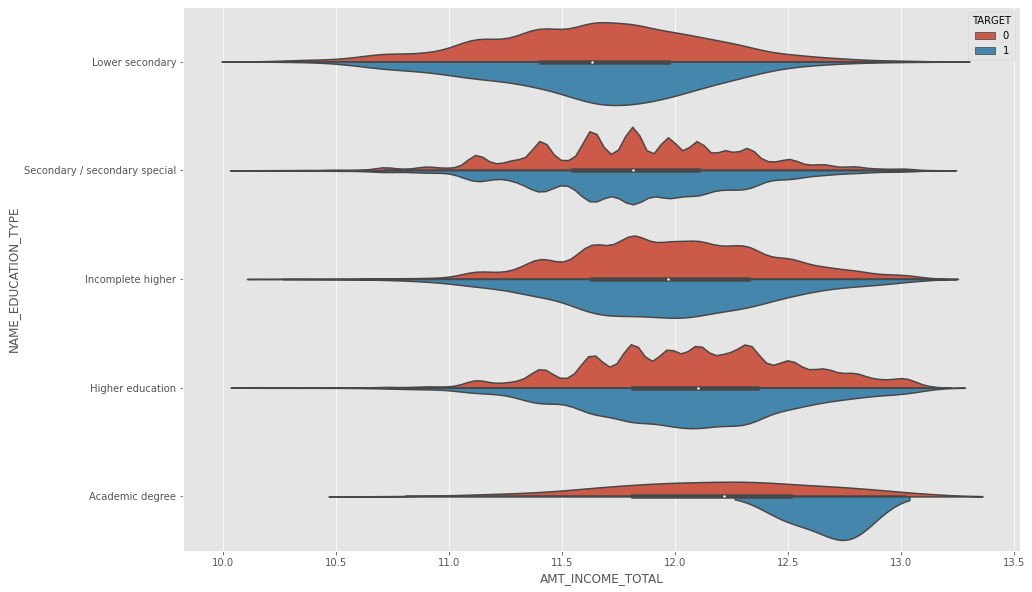

In [ ]:
condition = app_train.AMT_INCOME_TOTAL < 500000
# print(app_train)
sns.violinplot(y = app_train.NAME_EDUCATION_TYPE[condition], x = (app_train.AMT_INCOME_TOTAL[condition]), hue = app_train.TARGET[condition], order = order, split  = True)
plt.show()
sns.violinplot(y = app_train.NAME_EDUCATION_TYPE[condition], x = np.log(app_train.AMT_INCOME_TOTAL[condition]), hue = app_train.TARGET[condition], order = order, split  = True)
plt.show()

In [ ]:
condition = app_train.AMT_INCOME_TOTAL < 500000
pd.crosstab(app_train.TARGET[condition], app_train.NAME_EDUCATION_TYPE[condition], values = app_train.AMT_INCOME_TOTAL, aggfunc = 'mean')

NAME_EDUCATION_TYPE,Academic degree,Higher education,Incomplete higher,Lower secondary,Secondary / secondary special
TARGET,,,,,
0,214441.176471,195806.274008,176135.405907,128501.203775,152661.330870
1,322500.000000,187430.985935,169967.001742,129005.395683,151665.263495


In [ ]:
pd.crosstab(app_train.TARGET[condition], app_train.NAME_EDUCATION_TYPE[condition], values = app_train.AMT_INCOME_TOTAL, aggfunc = 'median')

NAME_EDUCATION_TYPE,Academic degree,Higher education,Incomplete higher,Lower secondary,Secondary / secondary special
TARGET,,,,,
0,202500.0,180000.0,157500.0,112500.0,135000.0
1,337500.0,180000.0,157500.0,117000.0,135000.0


<AxesSubplot:xlabel='AMT_GOODS_PRICE', ylabel='NAME_EDUCATION_TYPE'>

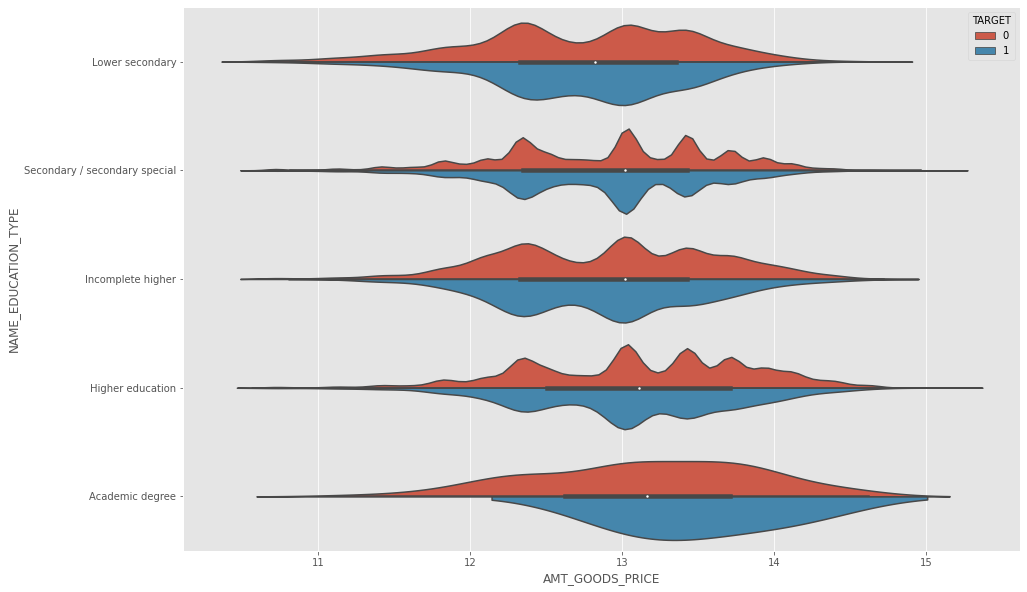

In [ ]:
sns.violinplot(y = app_train.NAME_EDUCATION_TYPE, x = np.log(app_train.AMT_GOODS_PRICE), hue = app_train.TARGET, split = True, order = order)
# amount of goods shows a similar trend but nowhere near the extreme of the amount income trend

In [ ]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0


3
/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='TARGET', ylabel='count'>

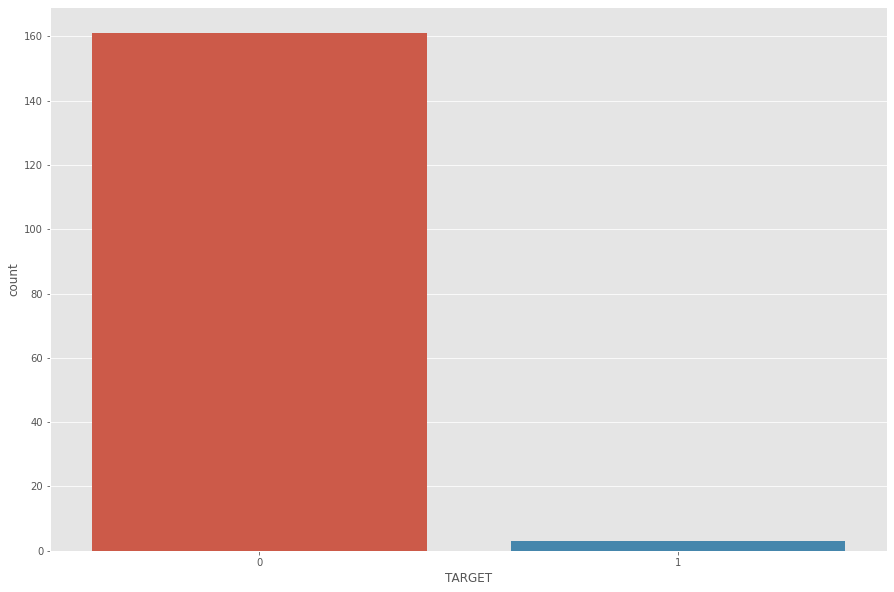

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
print(len(app_train.NAME_EDUCATION_TYPE[(app_train.NAME_EDUCATION_TYPE == "Academic degree") & (app_train.TARGET == 1)]))
sns.countplot(app_train.TARGET[app_train.NAME_EDUCATION_TYPE == "Academic degree"])
# sns.violinplot(x = app_train.AMT_INCOME_TOTAL[condition], y = pd.Categorical(app_train.CNT_CHILDREN[condition]), hue = app_train.TARGET[condition])

<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='Density'>

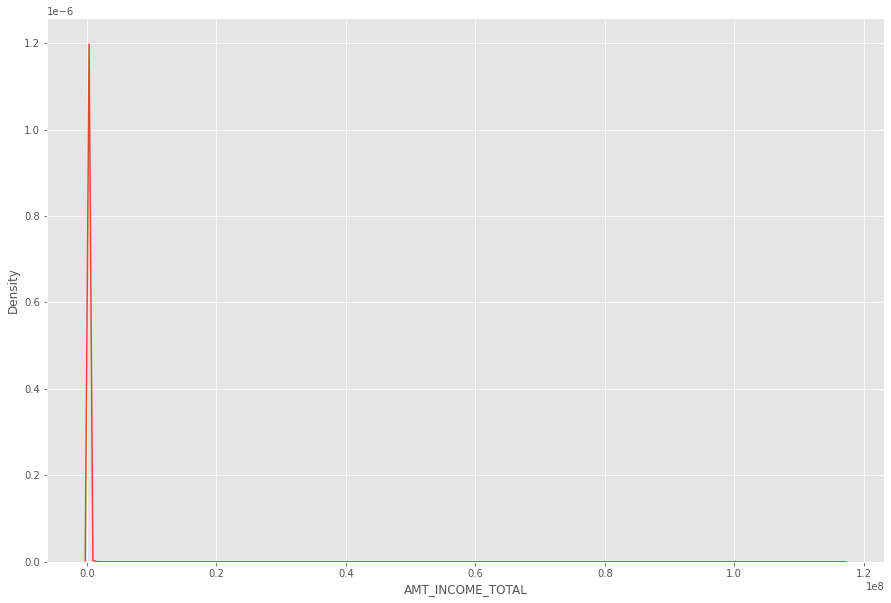

In [ ]:
sns.kdeplot(app_train[app_train.TARGET == 1].AMT_INCOME_TOTAL)

### Target Variable Analysis

In [ ]:
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0,0,0,0,0,0


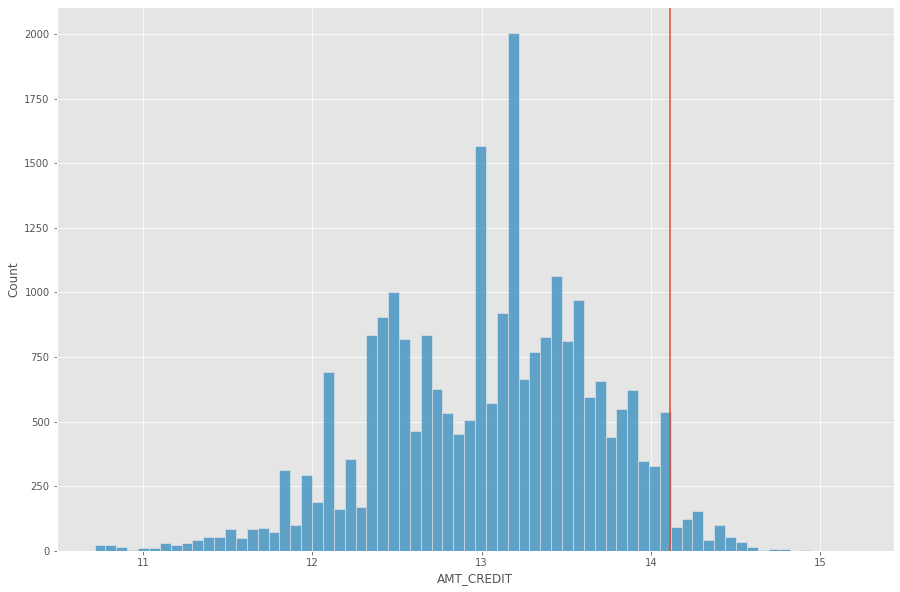

In [ ]:
quant = 0.95
sns.histplot(np.log(app_train[app_train.TARGET == 1].AMT_CREDIT))
plt.axvline(np.log(app_train.AMT_CREDIT.quantile(quant)))
plt.show()

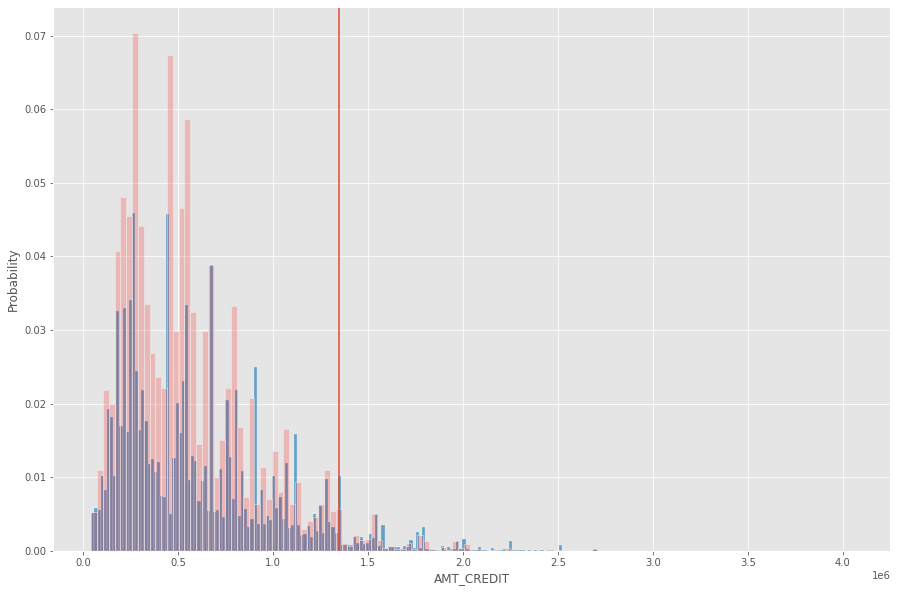

In [ ]:
stat = "probability"
sns.histplot(app_train.AMT_CREDIT[app_train.TARGET == 0], stat = stat)
sns.histplot(app_train.AMT_CREDIT[app_train.TARGET == 1], stat = stat, color = "red", alpha = 0.2)
plt.axvline((app_train.AMT_CREDIT.quantile(quant)))

<AxesSubplot:xlabel='AMT_CREDIT', ylabel='Density'>

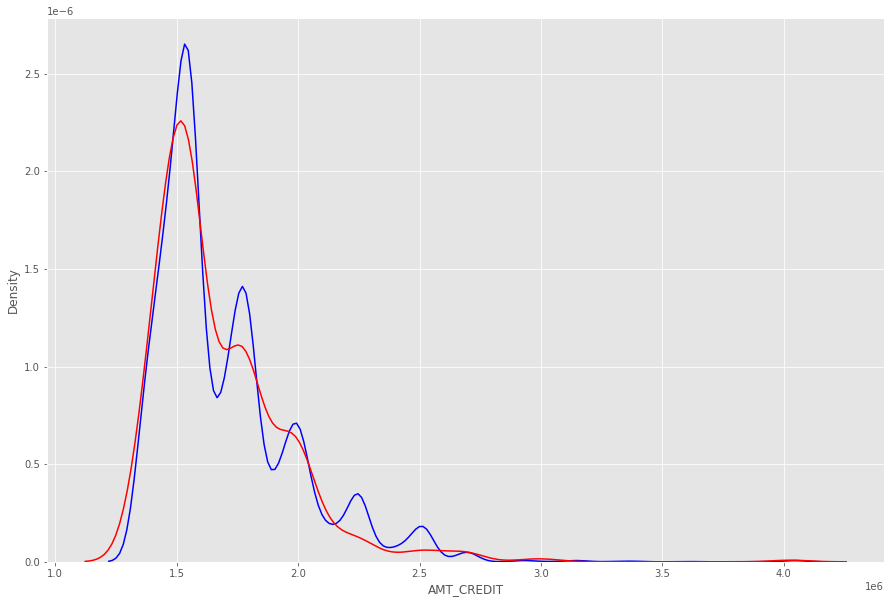

In [ ]:
quant_cond = app_train.AMT_CREDIT > app_train.AMT_CREDIT.quantile(0.95)
sns.kdeplot(app_train.AMT_CREDIT[(app_train.TARGET == 0) & quant_cond], color = "blue")
sns.kdeplot(app_train.AMT_CREDIT[(app_train.TARGET == 1) & quant_cond], color = "red", alpha = 0.2)
# plt.axvline((app_train.AMT_CREDIT.quantile(quant)))

In [ ]:
print(app_train.AMT_CREDIT.quantile(quant))
app_train[app_train.AMT_CREDIT > app_train.AMT_CREDIT.quantile(quant)]

1350000.0


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,...,0,0,1,0,0,0,0,0,0,0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,...,0,0,0,0,0,0,0,0,0,0
49,100056,0,Cash loans,M,Y,Y,0,360000.0,1506816.0,49927.5,...,0,0,0,0,0,0,0,0,0,0
60,100071,0,Cash loans,F,N,Y,0,180000.0,1663987.5,86989.5,...,0,0,0,0,0,0,0,0,0,0
116,100136,0,Cash loans,M,Y,N,1,157500.0,1571931.0,49356.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307409,456142,0,Cash loans,F,N,N,1,360000.0,1417185.0,39100.5,...,0,0,0,0,0,0,0,0,0,0
307422,456155,0,Cash loans,F,N,Y,0,202500.0,1971072.0,68643.0,...,0,0,0,0,0,0,0,0,0,0
307438,456176,1,Cash loans,M,N,Y,0,171000.0,1436850.0,42142.5,...,0,0,0,0,0,0,0,0,0,0
307476,456216,0,Cash loans,F,N,N,2,135000.0,1762110.0,48456.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(app_train.AMT_ANNUITY.isnull().sum())
app_train[app_train.AMT_ANNUITY.isnull()]

12


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
47531,155054,0,Cash loans,M,N,N,0,180000.0,450000.0,NaN,...,0,0,0,0,0,0,0,0,0,0
50035,157917,0,Cash loans,F,N,N,0,94500.0,450000.0,NaN,...,0,0,0,0,0,0,0,0,0,0
51594,159744,0,Cash loans,F,N,N,0,202500.0,539100.0,NaN,...,0,0,0,0,0,0,0,0,0,0
55025,163757,0,Cash loans,F,N,N,0,162000.0,296280.0,NaN,...,0,0,0,0,0,0,0,0,0,0
59934,169487,0,Cash loans,M,Y,N,0,202500.0,360000.0,NaN,...,0,0,0,0,0,0,0,0,0,0
75873,187985,0,Cash loans,M,Y,N,0,144000.0,219249.0,NaN,...,0,0,0,0,0,0,0,0,0,0
89343,203726,0,Cash loans,F,Y,N,0,90000.0,157500.0,NaN,...,0,0,0,0,0,0,0,0,0,0
123872,243648,0,Cash loans,F,N,Y,0,202500.0,929088.0,NaN,...,0,0,0,0,0,0,0,0,0,0
207186,340147,0,Cash loans,M,N,N,0,171000.0,486000.0,NaN,...,0,0,0,0,0,0,0,0,0,0
227939,364022,0,Cash loans,F,N,Y,0,315000.0,628069.5,NaN,...,0,0,0,0,0,0,0,0,0,0


## Summary
- People with revolving loans tend to be approved at lower credit amount than people who applied for cash loans, likely because they are credit lines to purchase inexpensive goods. 
- Interestingly, people with revolving credit lines tend to purchase goods that are more expensive than the amount of credit they were approved for while the vast majority of cash loan borrowers stayed within their limit. 
    - makes sense since I would assume cash loans are loaned out for a singular purchase and cannot be used for anything else, such as purhasing a car or home. 
    - revolving loans can be used for almost anything, explaining why theyre credit limit is much lower compared to cash loans. 
- As expecteed, people with lower levels of education have difficulty making the payments for their loans at higher rates than the more educated people, but not significantly so. 
- Since the dataset does not describe what the education types are or their order, I am assuming the order goes: lower sec, secondary, higher, and finally academic being the highest, judging from the amount of each.
    - on average, the income the borrower reported increased as the level of education also increased, which is typically normal
    - what was not expected was that out the education categories, the people who had an academic degree and had payment difficulties earned the highest on average, significantly more than every other category. Why tho? 
        - there are only 3 people with academic degrees that had difficulties making the payments, the violinplot only shows the variability between, makes for a misleading graphic

## Distribution of "Losses"

In [4]:
losses = app_train[app_train.TARGET == 1]
losses.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0,0,0,0,0,0
26,100031,1,Cash loans,F,N,Y,0,112500.0,979992.0,27076.5,...,0,0,0,0,1,0,0,0,0,0
40,100047,1,Cash loans,M,N,Y,0,202500.0,1193580.0,35028.0,...,0,0,0,0,0,0,0,0,0,0
42,100049,1,Cash loans,F,N,N,0,135000.0,288873.0,16258.5,...,0,0,0,0,0,0,0,0,0,0
81,100096,1,Cash loans,F,N,Y,0,81000.0,252000.0,14593.5,...,0,0,0,0,0,0,0,0,0,0


In [46]:
gauss_data = np.random.normal(size = 5000, loc = np.log(np.mean(losses.AMT_CREDIT)), scale = np.log(np.std(losses.AMT_CREDIT)))


In [42]:
print(
    np.log(np.mean(losses.AMT_CREDIT)), np.mean(np.log(losses.AMT_CREDIT)), "\n",
    np.log(np.std(losses.AMT_CREDIT)), np.std(np.log(losses.AMT_CREDIT))
)

13.231717258765737 13.040707195226679 
 12.75542525553593 0.6405442094716115


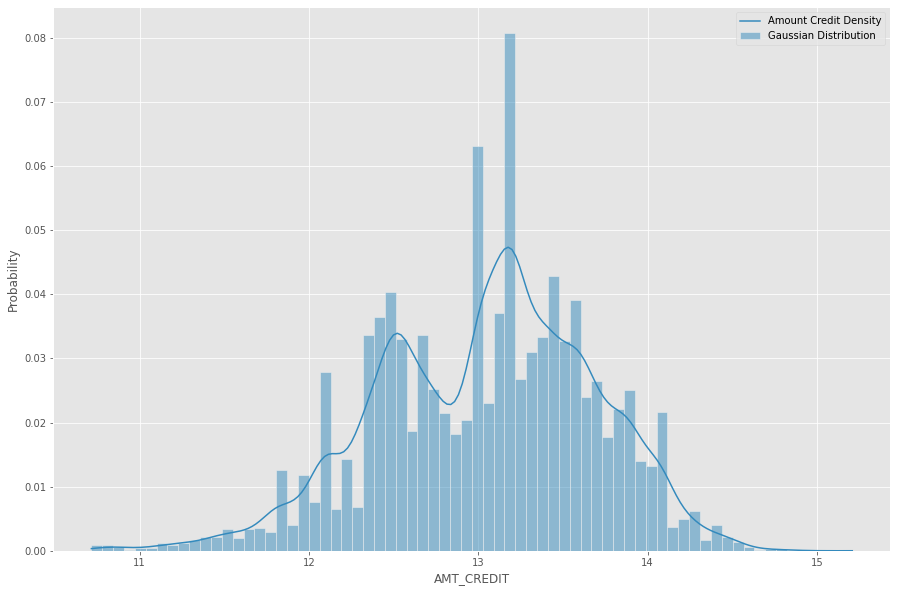

In [48]:
sns.histplot(np.log(losses.AMT_CREDIT),stat = "probability", kde = True)
# sns.kdeplot(gauss_data, color = "black")
plt.legend(["Amount Credit Density", "Gaussian Distribution"])

In [16]:
stats.shapiro(np.log(losses.AMT_CREDIT))

/shared-libs/python3.7/py/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9908922910690308, pvalue=2.776115302374701e-36)

In [17]:
stats.jarque_bera(np.log(losses.AMT_CREDIT))

Jarque_beraResult(statistic=415.68700801544054, pvalue=0.0)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9263f292-ea73-48e7-8892-f3d3ed1db03c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>